
# Testing different implementations of SRT

## Packages

In [ ]:
%pylab inline
from collections import Counter, defaultdict
from scipy.stats import bernoulli
from scipy.stats import binom
import numpy as np

import multiprocessing

import torch
import torch.multiprocessing as mp

import matplotlib.pyplot as plt
import math
from sympy import symbols, Eq, solve, exp, log

Populating the interactive namespace from numpy and matplotlib


##Sample Randomize and Threshold (SRT)

### Algorithm


#### SRT v1

In [ ]:
#Estimation of SRT with correction

def SRT_v1(X, B, t0, t1, ps, tau):
    n = len(X)
    elements = []
    for el in range(1, B+1):
        elements.append(el)

    #Calculating true count
    cx = Counter(X)

    #Calculating true relative frequency
    phix = defaultdict(int)
    for k in cx.keys():
        phix[k] = cx[k] / n

    #Randomization
    X_rand = []
    for x in X:
        ex = [0] * (B+1)
        ex[x] = 1
        for i in range(1, len(ex)):
            if ex[i] == 1:
                ex[i] = bernoulli.rvs(t1)
            else:
                ex[i] = bernoulli.rvs(t0)
        for i in range(len(ex)):
            if ex[i] == 1:
                X_rand.append(i)

    #Sampling (the implementation is different)
    sample = []
    for a in X_rand:
        rv = bernoulli.rvs(ps)
        if rv:
            sample.append(a)
    calg = Counter(sample)

    #Thresholding
    for k in calg.keys():
        if calg[k] < tau:
            calg[k] = 0
        # correction
        if calg[k] > 0:
            calg[k] = int ((calg[k] - n * ps * t0) / (ps * (t1-t0)) )

    #Calculating estimated relative frequency (with the total size = total nonzer counts)
    phialg = defaultdict(int)
    total_app = sum(list(calg.values()))
    for k in calg.keys():
        phialg[k] = calg[k] / total_app

    return cx, phix, calg, phialg

#### SRTv2

In [ ]:
import torch
from collections import Counter, defaultdict

def encode_and_randomize(x, B, t0, t1, device):
    # Create tensors directly on the appropriate device
    one_hot_vector = torch.zeros(B+1, device=device)
    one_hot_vector[x] = 1
    encoded_vector = torch.where(one_hot_vector == 0,
                                 torch.bernoulli(torch.full((B+1,), float(t0), device=device)),
                                 torch.bernoulli(torch.full((B+1,), float(t1), device=device)))
    return encoded_vector

def SRT_v2(X, B, t0, t1, ps, tau, device='cuda'):

    n = len(X)

    # Calculating true count
    cx = Counter(X)

    # Calculating true relative frequency
    phix = {k: v / n for k, v in cx.items()}

    matrix2 = torch.empty((n, B+1), device=device)

    for i, x in enumerate(X):
        encoded_vector = encode_and_randomize(x, B, t0, t1, device)
        matrix2[i] = encoded_vector

    matrix1 = torch.bernoulli(torch.full((1, n), float(ps), device=device))
    result = torch.matmul(matrix1, matrix2)

    X_rand = result.cpu().tolist()
    calg = X_rand[0]

    # Thresholding
    for k in range(len(calg)):
        calg[k] = int((calg[k] - n * ps * t0) / (ps * (t1 - t0)))
        if calg[k] < tau:
            calg[k] = 0

    # Calculating estimated relative frequency (with the total size = total non-zero counts)
    total_app = sum(calg)
    phialg = {k: calg[k] / total_app for k in range(B)}

    return cx, phix, calg, phialg

### Parameter tuning (Randomization mechanism)

In [ ]:

#algorithm
#SRT parameter tuning
def solve_system_SRT(n, tau, epsilon, delta):
    A = ((log(1/delta) / (2 * n))**(1/2)).evalf()
    t_1 = 1/2

    #x = p
    #y = t0
    # Define the symbols
    x, y = symbols('x y', real=True, nonnegative=True)

    # Define the equations
    equation_1 = Eq((n - tau) * x**2 * y**2 + ((tau + 1 - n) / 2) * x**2 * y + (exp(-2 * epsilon) - 1) * tau * x * y - (tau / 4) * x**2 + (1 - exp(-2 * epsilon)) * (tau / 2) * x + (1 - exp(-2 * epsilon)) * A * n, 0)
    equation_2 = Eq(exp(-epsilon) * x * y - (1 / 2) * x + 1 - exp(-epsilon), 0)

    # Solve the system of equations for x and y
    solutions = solve((equation_1, equation_2), (x, y))

    #print("All solutions:(p, t0)=", solutions)

    #Find the solution with p and smaller t0
    #print(f"Number of solutions = {len(solutions)}")
    solutions.sort(key = lambda x:x[0])
    sol = solutions[0]
    #print(f"The solution is p={sol[0]}, t_0={sol[1]}")

    #verifying if y is also the minimum when x is the minimum
    y_solutions = [s[1] for s in solutions]
    y_solutions.sort()
    if y_solutions[0] < sol[1]:
      print(f"Warning:the solution does not have the minimum t_0")

    if sol[0] < 1:
      ep_0 = log((1-sol[1]) / sol[1])
      return sol[0], sol[1], ep_0

    x, y, ep_0 = solve_system_SRT(n, tau, 0.5, delta)
    print(f"epsilon = 0.5")
    return x, y, ep_0

"""
    if sol[0] > 0.5:
      print(f"Warning:p={sol[0]} > 0.5")
      sol = (0.5, sol[1])
      print(f"The solution is p={sol[0]}, t_0={sol[1]}")
      ep_new, del_new = calculate_epsilon_delta(sol[1], t_1, sol[0], tau, n)
      if ep_new <= epsilon and del_new <= delta:
        print("OK")
      else:
        print("NOT OK")
        print(f"ep_new = {ep_new:.3f}")
        print(f"del_new = {del_new:.3f}")

    if sol[1] > 0.5:
      print(f"Warning:p={sol[1]} > 0.5")
      sol = (0.5, sol[1])
      print(f"The solution is p={sol[0]}, t_0={sol[1]}")
      ep_new, del_new = calculate_epsilon_delta(sol[1], t_1, sol[0], tau, n)
      if ep_new <= epsilon and del_new <= delta:
        print("OK")
      else:
        print("NOT OK")
        print(f"ep_new = {ep_new:.3f}")
        print(f"del_new = {del_new:.3f}")

    ep_0 = log((1-sol[1]) / sol[1])
    print(f"ep_0 = {ep_0:.3f}")
"""

def calculate_epsilon_delta(t_0, t_1, p, tau, n):
    # Calculating q
    q = (1 - p * t_1) / (1 - p * t_0)

    # Calculating denominator
    D = (1-q**2 + p * (t_0 - t_1))*(t_1 - t_0)

    # Calculating alpha from tau
    alpha = (D * tau / (n*t_0) + 1) / (1-q**2) -1

    # Calculating epsilon
    epsilon = math.log(1 / q)

    # Calculating delta
    #print(-2 * n * alpha**2 * p**2 * t_0**2)
    delta = (math.exp(-2 * n * alpha**2 * p**2 * t_0**2) )

    return epsilon, delta

In [ ]:
def OUE(eps, delta, n, eps_0, tune_p = False, optional_p = 1):
    t1 = 1/2
    t0 = 1/(np.exp(eps_0 / 2) + 1)

    p = (np.exp(eps) - 1) / (np.exp(eps) * t1 - t0)
    if p > 1:
      p = min(p, 1)
      print("Warning: p > 1, the privacy guarantee eps will be smaller than the assigned.")
      print("original epsilon = {}; new epsilon = {}".format(eps, np.log((1-p*t0) / (1-p*t1))) )
    if tune_p:
      p = min([p, optional_p])
      print("Warning: p is tuned. ")
      print("original epsilon = {}; new epsilon = {}".format(eps, np.log((1-p*t0) / (1-p*t1))) )

    q = (1-p*t1) / (1 - p*t0)
    eta = (1 - q**2) - p*t1 + p*t0
    alpha = np.sqrt( np.log(delta) / (-2 * n * p**2 * t0**2))
    tau = ( (1 + alpha) * (1 - q**2) * n * p * t0 / eta - n * t0 ) / (t1 - t0)
    return t1, t0, float(p), tau

In [ ]:
def DE(eps, delta, n, eps_0, B, tune_p = False, optional_p = 1):
    t1 = np.exp(eps_0) / (np.exp(eps_0) + B - 1)
    t0 = 1 / (np.exp(eps_0) + B - 1)

    p = (np.exp(eps) - 1) / (np.exp(eps) * t1 - t0)
    if p > 1:
      p = min(p, 1)
      print("Warning: p > 1, the privacy guarantee eps will be smaller than the assigned.")
      print("original epsilon = {}; new epsilon = {}".format(eps, np.log((1-p*t0) / (1-p*t1))) )
    if tune_p:
      p = min([p, optional_p])
      print("Warning: p is tuned. ")
      print("original epsilon = {}; new epsilon = {}".format(eps, np.log((1-p*t0) / (1-p*t1))) )

    q = (1-p*t1) / (1 - p*t0)
    eta = (1 - q**2) - p*t1 + p*t0
    alpha = np.sqrt( np.log(delta) / (-2 * n * p**2 * t0**2))
    tau = (1 + alpha) * (1 - q**2) * n * p * t0 / eta
    return t1, t0, p, tau

In [ ]:
def SYM(eps, delta, n, eps_0, tune_p = False, optional_p = 1):
    t1 = np.exp(eps_0 / 2) / (np.exp(eps_0 / 2) + 1)
    t0 = 1 / (np.exp(eps_0 / 2) + 1)

    p = (np.exp(eps) - 1) / (np.exp(eps) * t1 - t0)
    if p > 1:
      p = min(p, 1)
      print("Warning: p > 1, the privacy guarantee eps will be smaller than the assigned.")
      print("original epsilon = {}; new epsilon = {}".format(eps, np.log((1-p*t0) / (1-p*t1))) )
    if tune_p:
      p = min([p, optional_p])
      print("Warning: p is tuned. ")
      print("original epsilon = {}; new epsilon = {}".format(eps, np.log((1-p*t0) / (1-p*t1))) )


    q = (1-p*t1) / (1 - p*t0)
    eta = (1 - q**2) - p*t1 + p*t0
    alpha = np.sqrt( np.log(delta) / (-2 * n * p**2 * t0**2))
    tau = (1 + alpha) * (1 - q**2) * n * p * t0 / eta
    return t1, t0, p, tau

## Sample and Threshold (ST)

###Algorithm

In [ ]:
#Estimation of ST with correction

def ST_sim(X, B, ps, tau):
    n = len(X)

    #counting true frequency
    cx = Counter(X)

    #obtaining true relative frequency
    phix = defaultdict(int)
    for k in cx.keys():
        phix[k] = cx[k] / n

    #sampling
    sample = []
    for a in X:
        rv = bernoulli.rvs(ps)
        if rv:
            sample.append(a)
    calg = Counter(sample)

    calg[k] = int(calg[k] / ps)  # correction
    #tau_corrected = tau / ps
    #thresholding
    for k in calg.keys():
        if calg[k] < tau:
            calg[k] = 0

    #obtaining estimated relative frequency
    phialg = defaultdict(int)
    total_app = sum(list(calg.values()))
    for k in calg.keys():
        phialg[k] = calg[k] / total_app

    return cx, phix, calg, phialg

#cx = true count
#phix = true relative frequency
#calg = estimated count after ST
#phialg = estimated relative frequency

### Parameter Tuning

In [ ]:
def st_param(eps, delta, alpha = 0.2):
    if eps > 1:
      print("Warning of ST: eps is not allowed")
    ps = alpha * (1 - np.exp(-eps))
    Calp = np.log(1/alpha) - 1/(1+alpha)
    if Calp < 0:
      print("Warning of ST: C_alpha < 0")
    tau = 1 / Calp * np.log(1 / delta)
    return ps, tau / ps

##Unary Encoding (UE)

###Algorithm

In [ ]:
#Algorithm of unary encoding

import torch
from collections import Counter, defaultdict

def encode_and_randomize(x, B, t0, t1, device):
    # Create tensors directly on the appropriate device
    one_hot_vector = torch.zeros(B+1, device=device)
    one_hot_vector[x] = 1
    encoded_vector = torch.where(one_hot_vector == 0,
                                 torch.bernoulli(torch.full((B+1,), float(t0), device=device)),
                                 torch.bernoulli(torch.full((B+1,), float(t1), device=device)))
    return encoded_vector

def UE(X, B, t0, t1, ps, tau, device='cuda'):
    n = len(X)

    # Calculating true count
    cx = Counter(X)

    # Calculating true relative frequency
    phix = {k: v / n for k, v in cx.items()}

    matrix2 = torch.empty((n, B+1), device=device)

    for i, x in enumerate(X):
        encoded_vector = encode_and_randomize(x, B, t0, t1, device)
        matrix2[i] = encoded_vector

    matrix1 = torch.bernoulli(torch.full((1, n), 1.0, device=device))
    result = torch.matmul(matrix1, matrix2)

    X_rand = result.cpu().tolist()
    calg = X_rand[0]

    # Thresholding
    for k in range(len(calg)):
        calg[k] = int((calg[k] - n * 1 * t0) / (1 * (t1 - t0)))


    # Calculating estimated relative frequency (with the total size = total non-zero counts)
    total_app = sum(calg)
    phialg = {k: calg[k] / total_app for k in range(B)}

    return cx, phix, calg, phialg

def UE_raw(X, B, t0, t1, ps, tau, device='cuda'):

    n = len(X)

    # Calculating true count
    cx = Counter(X)

    # Calculating true relative frequency
    phix = {k: v / n for k, v in cx.items()}

    matrix2 = torch.empty((n, B+1), device=device)

    for i, x in enumerate(X):
        encoded_vector = encode_and_randomize(x, B, t0, t1, device)
        matrix2[i] = encoded_vector

    matrix1 = torch.bernoulli(torch.full((1, n), 1.0, device=device))
    result = torch.matmul(matrix1, matrix2)

    X_rand = result.cpu().tolist()
    calg = X_rand[0]


    # Calculating estimated relative frequency (with the total size = total non-zero counts)
    total_app = sum(calg)
    phialg = {k: calg[k] / total_app for k in range(B)}

    return cx, phix, calg, phialg

###Parameter Tuning

In [ ]:
#Parameter Tuning of Unary Encoding

def ue_param(eps):
  t1 = 1/2
  t0 = 1/(np.exp(eps)+1)
  return t1, t0

## Exp. $B = 2^{8}$.

### Implementation

In [ ]:
#Comparing top k elements
#Index 0 is ST
#Index 1 is UE
#Index 2 is SRT

Eps = [0.1, 0.5, 1]
#Eps = [ 1 ]
Trials = 10

k = 5

delta = 1e-6
B = 2**8
n = 10**5

#storing data
Dataset = []

#define max errors
Err0_max = []
Err1_max = []
Err2_max = []

#define min errors
Err0_avg = []
Err1_avg = []
Err2_avg = []

#Checking GPU
if torch.cuda.is_available():
    device = "cuda"
    print("GPU is available")
else:
    device = "cpu"
    print("GPU is unavailable")

for epsilon in Eps:

  #Tuning ST parameters
  p_st, tau_st = st_param(epsilon, delta, alpha = 1/6)
  print( f"ST parameters: p = {p_st}, tau = {tau_st}" )

  #Tuning UE parameters
  t1_ue, t0_ue = ue_param(epsilon)
  print( f"UE parameters: t1 = {t1_ue}, t0 = {t0_ue}" )

  """
  #Tuning SRT parameters
  eps_0 = 10
  optional_p = 0.5
  t1, t0, p_srt, tau_srt = OUE(epsilon, delta, n, eps_0)
  print( f"SRT parameters: t1 = {t1}, t0 = {t0}, p_srt = {p_srt}, tau = {tau_srt}" )
  if p_srt == 1.0:
    print( f"Warning: tighter epsilon guarantee of SRT at epsilon = {epsilon}" )
  """

  #Retuning SRT parameters
  t1 = 1/2
  tau_srt = 100
  p_srt, t0, ep0 = solve_system_SRT( n, tau_srt, epsilon/2, delta/2 )
  print(f"SRT parameters: t1 = {t1}, t0 = {t0}, p_srt = {p_srt}, tau = {tau_srt}, ep0 = {ep0}")

  #define max errors
  Err0_max_temp = []
  Err1_max_temp = []
  Err2_max_temp = []

  #define min errors
  Err0_avg_temp = []
  Err1_avg_temp = []
  Err2_avg_temp = []

  for trials in range(Trials):

      #Creating random binomial samples
      X = binom.rvs(n = B, p=0.4, size=n)

      #Implementing ST
      cx0, phix0, calg0, phialg0 = SRT_v2( X, B, 0.0, 1.0, p_st, tau_st, device )
      print("ST works")

      #Implementing UE
      cx1, phix1, calg1, phialg1 = UE( X, B, t0_ue, t1_ue, 1.0, 0.0, device )
      print("UE works")

      #Implementing SRT
      cx2, phix2, calg2, phialg2 = SRT_v2( X, B, t0, t1, p_srt, tau_srt, device )
      print("SRT works")

      if trials == 0:
        for i in range(B):
          if cx0[i] != cx2[i]:
            print("Error: real data does not match.")

      #storing data
      Dataset.append( [cx0, calg0, calg1, calg2] )

      #Measuring errors
      err0 = []
      err1 = []
      err2 = []
      k_frequent = cx0.most_common(k)

      for i in range(len(k_frequent)):
          entry = k_frequent[i][0]
          err0.append( abs( cx0[entry] - calg0[entry] ) / n )
          err1.append( abs( cx0[entry] - calg1[entry] ) / n )
          err2.append( abs( cx0[entry] - calg2[entry] ) / n )

      if len(err0) == 0:
          err0.append(0)
      if len(err1) == 0:
          err1.append(0)
      if len(err2) == 0:
          err2.append(0)

      Err0_max_temp.append(max(err0))
      Err1_max_temp.append(max(err1))
      Err2_max_temp.append(max(err2))

      Err0_avg_temp.append(mean(err0))
      Err1_avg_temp.append(mean(err1))
      Err2_avg_temp.append(mean(err2))

      #print("checkpoint: trials =  ", trials)

  Err0_max.append( mean(Err0_max_temp) )
  Err1_max.append( mean(Err1_max_temp) )
  Err2_max.append( mean(Err2_max_temp) )

  Err0_avg.append( mean(Err0_avg_temp) )
  Err1_avg.append( mean(Err1_avg_temp) )
  Err2_avg.append( mean(Err2_avg_temp) )

  print("checkpoint: epsilon =  ", epsilon)

GPU is available
ST parameters: p = 0.01586043032734008, tau = 932.0055029135224
UE parameters: t1 = 0.5, t0 = 0.47502081252106
SRT parameters: t1 = 0.5, t0 = 0.130480882880368, p_srt = 0.129749439592488, tau = 100
ST works
UE works
SRT works
ST works
UE works
SRT works
ST works
UE works
SRT works
ST works
UE works
SRT works
ST works
UE works
SRT works
ST works
UE works
SRT works
ST works
UE works
SRT works
ST works
UE works
SRT works
ST works
UE works
SRT works
ST works
UE works
SRT works
checkpoint: epsilon =   0.1
ST parameters: p = 0.06557822338122776, tau = 225.4103204004903
UE parameters: t1 = 0.5, t0 = 0.3775406687981454
SRT parameters: t1 = 0.5, t0 = 0.0333227416327919, p_srt = 0.466617542954436, tau = 100
ST works
UE works
SRT works
ST works
UE works
SRT works
ST works
UE works
SRT works
ST works
UE works
SRT works
ST works
UE works
SRT works
ST works
UE works
SRT works
ST works
UE works
SRT works
ST works
UE works
SRT works
ST works
UE works
SRT works
ST works
UE works
SRT wo

### Printing Data

In [ ]:
print("Err0_max = ", Err0_max)
print("Err1_max = ", Err1_max)
print("Err2_max = ", Err2_max)
print("Err0_avg = ", Err0_avg)
print("Err1_avg = ", Err1_avg)
print("Err2_avg = ", Err2_avg)
print("Dataset = ", Dataset)

Err0_max =  [0.007546, 0.004064, 0.003277]
Err1_max =  [0.106649, 0.017580000000000002, 0.0075179999999999995]
Err2_max =  [0.013333000000000001, 0.0032210000000000003, 0.0020620000000000005]
Err0_avg =  [0.0036634, 0.0020316, 0.0016912]
Err1_avg =  [0.050890000000000005, 0.010362, 0.0042258]
Err2_avg =  [0.006993200000000001, 0.0014928, 0.0010640000000000003]
Dataset =  [[Counter({103: 5117, 102: 5065, 101: 5056, 104: 4968, 100: 4906, 105: 4896, 99: 4636, 106: 4546, 98: 4375, 107: 4316, 97: 3984, 108: 3859, 96: 3732, 109: 3543, 95: 3280, 110: 3145, 94: 2819, 111: 2729, 93: 2527, 112: 2293, 92: 2113, 113: 2070, 91: 1832, 114: 1647, 90: 1415, 115: 1368, 89: 1199, 116: 1119, 88: 984, 117: 923, 118: 718, 87: 718, 86: 564, 119: 552, 120: 415, 85: 405, 121: 343, 84: 315, 122: 240, 83: 223, 82: 175, 123: 159, 124: 121, 81: 98, 80: 92, 125: 89, 79: 49, 126: 49, 78: 37, 127: 30, 128: 30, 77: 23, 76: 14, 74: 13, 130: 12, 75: 12, 131: 10, 129: 10, 132: 6, 72: 4, 136: 3, 73: 3, 70: 3, 138: 1, 134

### Inputing Data

In [ ]:
Dataset =  [[Counter({102: 5100, 101: 5077, 103: 5026, 104: 5000, 105: 4849, 100: 4834, 106: 4671, 99: 4517, 98: 4361, 107: 4213, 97: 4012, 108: 3905, 96: 3605, 109: 3548, 95: 3323, 110: 3128, 94: 2839, 111: 2836, 93: 2462, 112: 2368, 92: 2116, 113: 2077, 91: 1792, 114: 1698, 115: 1453, 90: 1438, 89: 1170, 116: 1119, 88: 955, 117: 918, 118: 720, 87: 719, 86: 596, 119: 586, 85: 437, 120: 398, 84: 316, 121: 312, 122: 225, 83: 214, 82: 173, 123: 173, 124: 137, 81: 118, 80: 87, 125: 71, 126: 56, 79: 46, 127: 38, 78: 30, 129: 28, 77: 21, 128: 20, 76: 20, 130: 12, 74: 8, 75: 7, 131: 5, 133: 4, 70: 3, 72: 3, 71: 3, 73: 2, 132: 1, 135: 1}), [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 945, 1134, 2143, 1134, 1450, 1387, 2711, 2774, 2521, 3404, 3972, 3656, 5107, 4917, 5737, 5485, 5485, 4161, 4602, 4602, 4287, 4161, 3341, 3278, 3278, 2395, 2332, 1891, 1954, 945, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [3519, -5007, -10451, 6161, 3679, 156, -2805, -803, 16450, 317, 1638, -1084, -6929, 7683, -8210, 2238, 477, 3519, -11292, 4480, 477, 837, 4800, -1804, 637, 797, -2205, -7769, -5647, 6802, 3439, -5407, 9884, -443, -7969, 2438, 1598, -2765, -3245, 4760, -1084, 4640, -3446, -5848, -443, 3319, 4960, -3966, 2038, 2638, -7169, -5527, -3446, 7763, 6322, 11726, -3966, -2685, -10171, -1444, -8410, -5127, 12887, -1684, -7329, 9524, -12213, -17457, 1397, -1204, 10365, -5247, -2445, -123, -5167, -3165, 12927, 3319, 517, -9571, -11412, -9371, 2358, 2879, 7162, -3406, -2405, -7129, 10405, -1044, 517, -4326, -9931, -5447, 2398, -523, -3806, 1037, -5087, -2245, 14688, -7009, 15529, 4800, 12206, 7523, 6001, 3599, -9050, 1157, 10565, 2719, -5367, 8363, -7009, -883, 5201, -7489, 36, -2805, -5087, 1958, -10692, 3279, -10932, 4640, -3686, 5601, -7329, -2605, -11172, -6168, 10205, -1444, 4400, -6848, 76, 2959, 15489, 2598, -4567, -6648, -6768, -5968, 3399, -8570, -10732, -7889, 7442, -3406, -683, -2125, 2038, 1958, -2485, 6562, 6121, -2325, 877, -2845, -6168, -7129, 2638, -723, -4126, 3359, 7082, -83, 3319, 7442, 1477, -403, -8290, 3039, -13654, 2478, 637, -603, 597, 957, 1998, -7089, 1157, 1197, -9931, 437, -5527, -123, 357, -3125, -11292, -1364, -563, 7523, -16697, -1324, -9931, -7729, 5000, 13968, -6008, -2725, -563, -1164, -203, -5127, -1604, -8650, 2118, -8530, 2919, -5808, 2558, 20213, -3205, 10445, 36, 1117, 5241, 2598, 3359, 11005, -11412, -7689, -1404, -3205, 6362, -2845, -9130, -1364, -803, 3239, 3960, 12367, -11452, 4320, 10925, 1718, -203, 9644, -4847, -203, -1084, 3479, 717, 397, 8563, -8290, -363, 7082, 8523, -9971, -683, -2525, -3766, 5040, 1638], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1546, 2080, 2508, 2155, 2091, 2540, 2871, 3908, 3609, 4431, 4560, 4955, 4282, 5009, 4966, 5522, 4506, 4549, 4634, 4154, 4228, 2860, 2925, 2027, 2070, 1418, 2369, 1931, 1845, 0, 0, 0, 0, 0, 0, 0, 0, 969, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1001, 0, 0, 0, 0, 1161, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]], [Counter({102: 5131, 101: 5125, 103: 5109, 100: 4914, 104: 4849, 105: 4785, 99: 4587, 106: 4532, 98: 4309, 107: 4234, 97: 4085, 108: 3904, 96: 3680, 109: 3552, 95: 3255, 110: 3139, 94: 2934, 111: 2818, 93: 2488, 112: 2406, 92: 2172, 113: 2030, 91: 1812, 114: 1674, 90: 1390, 115: 1378, 89: 1201, 116: 1126, 88: 921, 117: 833, 87: 770, 118: 707, 86: 610, 119: 544, 85: 461, 120: 389, 84: 318, 121: 298, 122: 244, 83: 217, 82: 168, 123: 146, 81: 116, 124: 112, 80: 97, 125: 87, 126: 61, 79: 54, 78: 36, 127: 36, 128: 33, 77: 25, 76: 19, 129: 19, 130: 14, 75: 12, 131: 10, 74: 8, 73: 5, 132: 3, 134: 3, 70: 2, 135: 1, 137: 1, 72: 1}), [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 945, 1639, 1765, 2711, 2585, 2206, 2711, 2963, 3782, 3719, 4098, 5170, 5611, 4350, 4791, 4350, 5043, 4728, 3341, 3656, 2963, 3341, 3152, 2206, 2080, 1891, 1702, 945, 0, 1260, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [5201, -203, -12974, 236, 5281, 5361, -1404, -4727, 76, 8724, -563, 8523, -8210, 10965, -883, 11406, -2205, -4246, -12333, 5241, -4166, 15009, -3205, 8203, -3406, 8243, 4440, -6728, 4400, 3879, -5567, -3526, 1838, 5481, -6008, -563, -1004, -6088, 12006, 1598, -3846, -7729, 2198, -1684, -6368, 8243, 4840, -1764, 1277, 1638, 6562, -843, -3566, 6041, 6121, -6648, -8530, 7883, -14295, 2558, 18652, 236, 116, 7763, 12807, -5968, -4927, -1764, -4927, -1604, -8089, 5281, -7649, 1918, -2565, 1918, -5127, 4680, 156, -5647, 6041, -11492, 11526, 2959, -3846, -5327, -5287, 1838, 10245, 797, -123, -43, 6802, 4280, 1397, 637, 4480, 4080, 3079, -12293, 2799, 5441, -2245, 4960, 9604, 12046, 2839, 5561, 14168, 837, 1998, 8203, -5487, 12367, 6201, -5928, -5367, 3119, -3165, -1564, 5681, 1518, 1598, 2759, -1644, 5040, -3446, -10491, 8043, 3920, 2398, -7769, 2278, 1317, 1918, -1724, 7402, -5848, -5247, 9884, 2398, 9364, -5087, -2685, 1518, -1924, 5561, 6041, 4520, 317, -12133, 10005, 2438, 357, 7442, 2919, -6568, -683, -2445, 7322, -6248, -3566, 10125, 9724, -2765, -3, -6568, -13654, 6482, -7689, -3966, -12493, 1678, -3566, -11092, -2805, -4807, -15616, -10612, -7889, -3406, 1317, 4240, -283, -2845, 4280, -5728, -2205, 1678, 4720, -2245, 2638, 3839, -3326, -6288, 3920, 10005, 3719, 2358, 8804, 2839, -1964, 3559, -2004, -3245, -7609, 6962, 5841, -4727, 14128, 2518, 877, -1244, -1244, -9891, -11692, -3085, -5567, -2565, 477, -4166, -403, 3519, 6322, 5040, 3279, 4240, 837, 837, 7563, 276, 10205, -3245, 2839, -3966, 10525, -4126, -11252, 2318, 4800, 12246, 5481, 9684, -363, -3165, -2725, -83, -924, -2805, 317, 7282, 1758, -10251, -8170, -723, 5521, -9130], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 915, 969, 0, 1343, 1493, 1696, 3149, 2946, 3641, 3865, 4164, 3438, 5137, 4912, 5383, 4367, 4421, 5094, 3705, 4036, 3929, 3491, 2711, 2401, 2882, 1984, 1161, 1386, 1118, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]], [Counter({102: 5204, 103: 5110, 101: 5040, 100: 4956, 104: 4920, 105: 4729, 99: 4625, 106: 4515, 98: 4359, 107: 4292, 97: 3970, 108: 3923, 96: 3620, 109: 3549, 95: 3325, 110: 3168, 94: 2831, 111: 2731, 93: 2513, 112: 2315, 92: 2140, 113: 2037, 91: 1853, 114: 1661, 90: 1452, 115: 1366, 116: 1205, 89: 1177, 88: 950, 117: 888, 87: 741, 118: 730, 86: 583, 119: 546, 85: 445, 120: 415, 121: 310, 84: 301, 83: 241, 122: 236, 123: 174, 82: 151, 124: 118, 81: 104, 125: 84, 80: 71, 126: 57, 79: 42, 127: 40, 78: 39, 128: 34, 77: 22, 129: 21, 76: 19, 75: 11, 131: 8, 132: 8, 74: 6, 130: 5, 73: 5, 133: 2, 134: 2, 135: 2, 72: 1, 71: 1, 138: 1}), [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 945, 945, 0, 1450, 1765, 1702, 2143, 3152, 3404, 2963, 2900, 3719, 5043, 4791, 5170, 4917, 5359, 5422, 5043, 3719, 3593, 3467, 3089, 2837, 2395, 1954, 2648, 1828, 1008, 1576, 1197, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [-7009, -8930, 6362, 5881, -3125, -1644, -1124, 8123, -5888, -1604, -2725, -203, 13728, -2004, 76, 1638, -243, 1197, 4200, -4086, -2965, -3846, -5527, -12493, 837, 6442, -3245, -7649, -7769, 15529, -4807, -6328, 1758, -683, 6201, -5007, -11853, -10411, -5647, -7929, 517, 1317, -7689, 15209, -6768, -6808, -10572, 2438, 2398, -1604, 997, -8009, 2038, -5567, -16416, 4440, 276, 6842, -8850, -11452, 5561, 7883, 4120, -7849, -6528, 8283, -2685, 11085, 6081, -3606, 6482, 757, 4400, 1117, -163, -8570, 4080, -7089, 637, -8930, 3279, 5000, 3799, -7649, 10845, 7202, -924, 12286, 14568, 6322, -3446, 2358, 917, 5040, 4480, 11566, 4720, 5441, 11566, 12327, 6041, 677, 15169, -4607, -2645, 2879, -4206, 9324, 11166, -2365, 3479, 1437, -3165, -2405, 1958, 9484, -5367, -2845, 917, -2725, 4800, 4560, 9604, -4006, -843, 5841, -3886, -7969, -5407, 8043, 3839, 6362, -964, -3125, 6161, -13814, -7289, 5201, 6962, 557, -2325, -4046, 6161, 2558, -7969, -14094, 5321, 2158, -5647, 437, 15449, 6322, 3599, 12046, 6161, 3920, 4920, 4520, 10725, 2158, -4006, 8163, 1157, -7969, 7082, 116, 8243, 12527, -4446, -7049, -12773, -3125, 1477, -4406, 2959, -1284, 4000, -523, 9804, 5080, -2965, -4126, 1117, -10131, 2678, 7042, 5881, 2278, -2084, 36, -1164, 3359, 7162, -7609, 717, 397, 7162, -7809, 3319, 1998, 76, -5928, 6121, 4160, -13054, 2198, 36, -6088, 557, -3, 8483, -5527, -1044, -4486, 997, 8363, 2959, -11332, 16090, 3479, 1678, 7322, 2158, -8970, -7569, -3926, -4607, -7289, 7002, -8770, -1844, -9971, -83, -6328, -2004, -8130, -1004, -1844, 5721, -9250, -10291, -10131, 8083, -2885, 7042, 997, -7729, -3205, -2645, 2919, -11692, 13928, 2478, 4960, -7129, -8009, -1604], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1065, 0, 1631, 2273, 1631, 2433, 1717, 3245, 3897, 3801, 3544, 4517, 4923, 4741, 5062, 6056, 5019, 4923, 4944, 3502, 3993, 3299, 3288, 2882, 2241, 1567, 0, 1183, 1140, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1097, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 958, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1161, 0, 0, 969, 0, 0, 0, 0, 0, 0, 0, 0, 1033, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]], [Counter({102: 5200, 103: 5179, 104: 5006, 101: 4999, 100: 4845, 105: 4683, 99: 4630, 106: 4599, 98: 4419, 107: 4277, 97: 4060, 108: 3842, 96: 3645, 109: 3553, 95: 3251, 110: 3154, 94: 2975, 111: 2679, 93: 2473, 112: 2360, 92: 2118, 113: 2106, 91: 1732, 114: 1694, 90: 1576, 115: 1402, 89: 1149, 116: 1100, 88: 906, 117: 865, 87: 740, 118: 724, 86: 582, 119: 516, 85: 430, 120: 414, 121: 291, 84: 285, 122: 231, 83: 228, 123: 189, 82: 170, 124: 128, 81: 106, 125: 79, 80: 64, 79: 60, 126: 58, 127: 41, 78: 40, 77: 39, 128: 28, 76: 20, 129: 14, 74: 11, 130: 7, 75: 6, 132: 5, 131: 4, 133: 4, 72: 3, 71: 3, 134: 2, 136: 1}), [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1197, 1702, 1513, 2017, 2458, 3719, 3909, 3404, 3530, 3530, 4476, 4539, 4791, 6115, 4539, 4665, 4728, 4854, 4098, 4287, 4791, 3530, 2837, 2458, 1891, 1576, 1134, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [-11652, 5841, 6402, -4286, -10131, 1638, 3279, 2919, 196, -3766, -3766, -7689, 1397, -4647, 14568, -2125, 4000, 5361, -3326, 517, 3960, 3839, 2158, 76, 8003, -363, -8290, -6808, -803, 4400, -3446, 3439, -1444, 1918, -883, 4160, -2965, 2638, 1598, -603, 637, 1678, -2084, 6281, 9965, -7729, 4840, 3279, 2598, 3639, -17257, 18772, -5928, 917, 8043, 10005, -5808, -1404, -523, 6121, 1598, -6448, 1197, 1518, 2999, 3199, 6121, -4206, 357, -3406, -10371, -6728, -6328, 5441, 1838, 4960, -15295, 2799, -3165, -4527, -3446, -3205, 5201, -3165, 2478, 1878, -3726, 2598, -14975, 5561, -163, 1397, 4440, 6201, 1518, 9404, 2719, 917, -5287, -2765, -7329, 12967, 9764, -7489, 11126, 3759, 3279, 19773, 437, -6448, 9364, -10011, 2959, 5281, 8563, 3679, -5567, 10805, -4687, 10965, 12286, -1724, 4680, -123, -6048, 10925, -9971, 2839, 4920, -6688, -3285, -11572, 757, 9604, 3199, 1037, 1598, -5207, 3199, -3766, 1878, -10331, -3686, 4960, -4727, 10165, -4847, 2879, -5087, -3285, 15970, -7609, -3045, 8123, 2158, 2278, -243, 1077, -6488, 1357, -12693, 3479, -3846, 116, -603, 8363, 6281, 7683, -2765, 7923, 1918, -3766, -4527, 15769, 3639, 9884, 6802, -6088, -1204, 4400, 116, 13047, 2038, 1518, -4166, 9965, -10892, -8410, 36, 1838, 5361, 2558, -5647, 17931, -4687, 1357, 3599, -4807, 10085, 3799, 3399, 2118, -6728, -9090, -6008, -6448, -7329, -4406, -4246, -4126, 3879, -8730, 2398, -12653, 3239, 236, -1124, 1077, 4240, 15009, -4406, -3566, -5247, -5287, 5881, 6041, -5647, -5687, -3966, 2118, 1678, -12253, -2845, 6842, 5921, -9811, 3159, 7923, -5687, -4326, 5601, 8243, -1204, 397, -3726, -4206, 7923, -2485, 7963, -7969, 4240, -3966, 5921, 8483, 8003, 2318, 5401], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 937, 1685, 0, 1076, 1738, 2807, 3726, 3480, 3363, 4100, 4164, 3715, 4431, 5051, 4581, 4720, 5009, 4848, 5618, 3918, 4250, 3405, 3566, 3224, 1995, 1450, 1375, 1033, 905, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1140, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]], [Counter({102: 5075, 103: 4988, 101: 4984, 104: 4956, 100: 4809, 105: 4796, 99: 4644, 106: 4596, 98: 4440, 107: 4360, 97: 4033, 108: 3879, 96: 3656, 109: 3631, 110: 3264, 95: 3254, 94: 2955, 111: 2797, 93: 2477, 112: 2361, 113: 2077, 92: 2026, 91: 1819, 114: 1627, 90: 1463, 115: 1351, 89: 1185, 116: 1097, 88: 951, 117: 928, 87: 707, 118: 701, 86: 579, 119: 555, 85: 423, 120: 378, 84: 318, 121: 311, 83: 252, 122: 239, 82: 174, 123: 167, 124: 109, 81: 109, 125: 103, 80: 85, 126: 53, 79: 41, 127: 39, 78: 36, 129: 24, 77: 24, 128: 17, 76: 17, 75: 14, 130: 11, 131: 8, 134: 6, 71: 4, 74: 3, 132: 3, 136: 3, 73: 2, 133: 2, 72: 1, 70: 1, 64: 1, 137: 1}), [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 945, 1324, 1639, 2711, 2395, 2963, 2900, 3404, 3846, 3593, 5548, 4035, 3972, 4854, 5611, 4602, 5485, 4980, 4728, 3593, 3593, 3719, 3152, 2711, 2711, 2269, 2080, 1387, 1576, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [8924, 5921, 116, 2438, 5761, 76, 2118, 4640, 16410, -3285, -7249, 877, -4006, 4280, 2759, 2558, -3326, -3446, 6161, 7563, 5921, 14048, -1004, 2198, -12573, -2004, -15896, 4880, -1204, -9010, -4406, -7249, -3165, -1364, 12166, -13934, 7282, -14615, 236, -10491, -83, 8123, -1604, 917, 797, -2365, -9090, 3759, 6322, -4046, 357, 7883, -163, 2678, 2919, -7649, 116, 1718, -723, -4086, 2919, -4927, 3079, 357, -11212, -6288, -6888, 6482, 4120, 3679, -9130, 5921, 5201, 3679, -1764, -2485, -3045, 1598, 677, 236, -843, -11292, -11933, -5007, 5801, -1124, 10805, 2638, 13327, -6088, -8690, 7002, 557, 4840, -9571, -3245, 5441, -2725, 16650, 11366, 6802, 14729, 957, 8724, 9644, 17331, -8490, -5407, 2318, 8764, 10845, 3920, -5407, 6201, -6368, 2078, -7689, 3679, 276, 3039, -12813, 4640, 5841, 6201, 2438, 8323, 5961, 7803, -4767, 4320, 2839, -4967, 2438, 3759, -3806, -1804, 3759, -3205, -6328, -5047, 8844, 2358, 196, 3599, 8924, 357, -11893, 14408, 5361, -3446, -10612, -4326, -2044, 8123, -2845, 6722, -4286, 4360, 3559, -1164, -4647, -8170, 9324, 2638, 3879, -2645, -1604, -12533, 8163, -4206, 6281, 357, -403, 1357, 797, 5441, -5687, -363, 10685, 997, -6688, 9164, -3205, -5888, 10725, 7002, 2839, -1444, -6368, 2638, -6848, -7569, -3366, 11766, 6682, 6281, 6001, 8403, -8810, 9084, 11085, -6408, -5447, 2398, -5728, 116, -1964, -1164, 4480, -5647, 10325, -3526, -10772, 517, 7803, 5121, -803, 3879, 5321, -3446, 3839, 9804, 797, -163, 4000, 4160, 3119, 3960, -7049, -9491, -3846, -2445, 6882, -4366, -4807, -1364, 6201, 6962, -1084, 5521, 4040, -7929, 3599, 5801, 8203, -4567, -123, 637, -1404, 957, 757, 12487, 3359, 317, 3920, -10211, 5921], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 937, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 905, 0, 1685, 1493, 1813, 1717, 2038, 3138, 3256, 2764, 3747, 3459, 4079, 4399, 4902, 5041, 5767, 4015, 4741, 4870, 4004, 5073, 3363, 3544, 3801, 2967, 2198, 2112, 2112, 1567, 1289, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1001, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 947, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]], [Counter({103: 5178, 102: 5101, 101: 5070, 105: 4808, 100: 4795, 104: 4762, 99: 4730, 106: 4581, 98: 4355, 107: 4222, 97: 4087, 108: 3799, 96: 3702, 109: 3601, 95: 3348, 110: 3224, 94: 2853, 111: 2751, 93: 2538, 112: 2340, 92: 2132, 113: 2036, 91: 1751, 114: 1695, 90: 1459, 115: 1381, 89: 1211, 116: 1120, 88: 976, 117: 926, 87: 699, 118: 691, 119: 545, 86: 525, 85: 421, 120: 414, 84: 336, 121: 307, 122: 262, 83: 221, 82: 170, 123: 149, 124: 106, 81: 100, 80: 96, 125: 91, 126: 66, 79: 47, 78: 40, 127: 36, 128: 31, 129: 23, 77: 22, 130: 14, 76: 13, 75: 10, 131: 10, 73: 6, 74: 5, 132: 4, 133: 3, 71: 2, 70: 1, 135: 1, 134: 1}), [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1197, 0, 1639, 1954, 1576, 2458, 1828, 2521, 2458, 4350, 4224, 5170, 4539, 5296, 4791, 5359, 5043, 4602, 5107, 4980, 4224, 4602, 3341, 2963, 2458, 2395, 1954, 1891, 1134, 1071, 945, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [10165, 36, 357, -7449, -4486, -8009, -2285, 1518, 5961, 12246, -11492, -1004, 2278, -1444, 3399, 5961, 14769, -2525, 2959, -5407, -8370, 1998, 14608, -6328, -3165, -3205, 3159, 5761, 3679, 3719, 5161, -4967, -8210, -483, 11846, -4126, -8009, -4166, -323, 236, -1044, -7049, 2598, -6008, -4767, 557, -2725, -3205, -8250, 8804, -3526, 4960, -6528, -5047, 4680, 3639, 14288, 6602, 5601, -9411, -1924, -4847, -6168, -5127, 10005, 8323, 2158, -403, -12093, -3926, -7889, 2999, -1804, 6041, 8804, 597, 5040, -7729, 6722, -5327, 3359, 6522, -4807, -3085, -3566, -5928, -6328, 9244, 10365, 7803, -10692, 2398, -4967, 7402, 1518, -483, 8043, 14088, 2518, 4680, 3079, -1724, -2845, 10045, 9324, 14488, 13007, 11206, 5040, 7963, 13327, -7969, -924, -9851, 5601, -9531, 10405, 3839, -2084, 4600, 2598, -3926, -2084, -243, -5367, 877, -6929, -1924, 9524, -5447, -9010, 4960, 7803, 2158, -6648, 4840, 1437, -5087, 4480, -10131, -6929, -10892, -2925, -6328, 11686, -7009, -2044, 5681, 9164, -4847, -10371, -1284, 236, -4727, -3406, 3759, 2678, -11893, -6328, -1444, -3606, -8530, 4640, -5968, 6041, 7282, -11733, 1117, 3159, -3205, 2518, -6328, -3966, 2759, 11166, 4040, 9364, 4800, 10405, -11452, -1084, 7523, 3319, -10131, 2358, -7129, -163, -2685, -6808, 10485, 3359, -763, -5007, 36, 2358, 9644, -7409, -14615, -2205, 3759, 18051, 5481, -3486, -4807, -10812, -10411, -2084, 3039, -2685, -83, 11886, -2645, -3686, 4240, 877, 3159, 1878, -5407, 5441, 12447, -2405, -3806, -1804, -3846, -2565, 4680, 1518, -6528, 1197, 8523, 477, 6121, 5361, -363, -5848, -3125, -3245, -8690, -5367, 19773, -5447, 7963, 5721, 2719, 11846, 9644, 6802, 5561, -9931, 6962, 3879, 2638, -4166, 4840, -2605, -3446, 4200], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1129, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1289, 1332, 1183, 1664, 2999, 2444, 2380, 3128, 3160, 2914, 4506, 4859, 3961, 4784, 5308, 5949, 4517, 5297, 5489, 3598, 3299, 3448, 3138, 2593, 2978, 1065, 1503, 915, 1354, 0, 1129, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1012, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 969, 0, 0, 0, 915, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1161, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1001, 0, 0, 0, 0, 0, 0, 0, 0, 0]], [Counter({103: 5107, 102: 5048, 104: 5008, 101: 5002, 100: 4904, 105: 4852, 106: 4633, 99: 4631, 98: 4348, 107: 4210, 97: 3961, 108: 3876, 96: 3683, 109: 3500, 95: 3408, 110: 3241, 94: 3000, 111: 2720, 93: 2537, 112: 2353, 92: 2043, 113: 1986, 91: 1776, 114: 1705, 115: 1389, 90: 1366, 116: 1138, 89: 1127, 88: 983, 117: 868, 87: 777, 118: 705, 119: 566, 86: 544, 85: 413, 120: 403, 121: 338, 84: 310, 83: 237, 122: 227, 123: 173, 82: 163, 81: 119, 124: 114, 80: 99, 125: 91, 126: 49, 79: 48, 78: 40, 127: 36, 77: 28, 128: 28, 129: 16, 76: 15, 130: 14, 131: 10, 75: 8, 133: 7, 72: 5, 74: 4, 132: 4, 134: 2, 66: 2, 71: 1, 73: 1}), [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1071, 1197, 1197, 1828, 1891, 2143, 2837, 3719, 3782, 4224, 4728, 4602, 5737, 5170, 5233, 5674, 4539, 4791, 4287, 4224, 3972, 3215, 3089, 2080, 2458, 2206, 1576, 1702, 1197, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [-1604, -10411, -14054, 12647, 3439, -4727, -8730, 797, -6768, 2358, 13127, 12807, 5361, 1878, 8323, 4560, 13247, -1164, 6241, 5561, -8530, 2078, -10972, -2084, 3559, 2438, -12893, 7042, 1077, 2278, 8884, 8924, -5087, -6128, -7009, -2004, 10605, -964, 6322, 14608, 1518, -5327, 6081, 2158, 4320, 6281, 2558, 397, -4847, -3526, -10812, 5681, 9004, -643, -9331, 236, 3119, 5641, 7042, 2238, 7923, 12967, 6362, 637, 597, 1558, -13454, -6929, -3005, -603, -2205, 7282, 4960, 5561, 1397, -6248, -883, -2125, 4200, 156, -2525, -4166, 13167, -2565, -4286, 1598, 5201, 1558, 10445, 2158, -5447, 5040, -3606, 2919, -1204, -4967, -5968, 11246, 8083, 12767, 76, 6281, 717, 16890, 7763, 8203, -523, 1678, -4647, -2245, 12647, 4720, -8490, 2318, -3926, 4080, 236, -203, -683, 12126, 5241, -10131, 1518, 1237, 4600, -6648, -3285, -5527, -7369, 4200, -4406, 8163, 1157, 1437, -6808, -4767, -1284, -8570, 12006, 12126, 4400, -12213, 2678, 1718, -283, 5521, 9164, -4446, -6568, 7442, 2478, 3399, 5281, -6248, 3039, -11652, -1164, -4767, 797, 2558, -15376, 717, 8243, 7322, 637, 2959, 7162, -3446, -4927, 1838, 8163, -3486, -7049, 1117, -1124, 2238, -8610, -3125, 10085, 8483, 13007, 4360, 8643, 3439, 2518, 1518, -1804, 12767, 13287, 9764, -2965, 3519, -803, 7362, -3205, 1117, 7482, 3719, -83, 5761, 1357, 4800, -9250, -5687, -9290, 4600, -9331, 11686, -763, 797, 1718, 2558, -8570, -1284, -523, -924, 837, 5841, 5721, -14495, 5201, 2558, 1077, 757, -2205, -843, 6161, -11973, -7569, -2685, 116, 2879, -563, -523, 1838, 10805, -3085, -483, -4366, -14135, -8170, -10772, 2959, -9691, 5281, 4360, -1284, 6442, 2999, 12246, -3125, -7929, 12166, -3, 6562, -9250, -1364], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1225, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1054, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1172, 1952, 0, 1151, 1300, 3373, 3042, 3587, 4186, 3715, 4111, 4303, 4709, 5650, 4346, 5372, 5329, 4912, 4068, 4442, 4068, 3694, 3470, 2134, 1781, 1225, 1364, 1439, 1204, 0, 1236, 0, 1108, 0, 0, 0, 0, 0, 0, 1012, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 947, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]], [Counter({103: 5060, 102: 5029, 101: 4911, 104: 4849, 100: 4838, 105: 4794, 106: 4670, 99: 4665, 98: 4400, 107: 4235, 97: 3994, 108: 3828, 96: 3680, 109: 3551, 95: 3328, 110: 3256, 94: 2938, 111: 2726, 93: 2467, 112: 2444, 92: 2216, 113: 2031, 91: 1805, 114: 1658, 90: 1442, 115: 1393, 89: 1270, 116: 1150, 88: 906, 117: 896, 87: 718, 118: 699, 86: 584, 119: 553, 120: 440, 85: 406, 84: 325, 121: 318, 83: 249, 122: 222, 82: 185, 123: 176, 81: 115, 124: 115, 125: 79, 80: 65, 79: 55, 126: 53, 78: 36, 127: 29, 128: 28, 129: 27, 77: 18, 76: 16, 130: 12, 74: 9, 75: 8, 73: 6, 131: 4, 71: 3, 70: 3, 133: 3, 132: 3, 136: 2, 134: 2, 138: 1, 137: 1, 68: 1, 135: 1}), [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1387, 945, 2080, 1197, 3278, 2774, 3782, 3656, 5296, 3467, 4791, 4413, 4917, 4980, 5107, 5170, 4665, 5043, 3782, 3215, 2963, 3404, 3026, 1765, 2206, 2143, 945, 1260, 1260, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [2358, 15129, -8089, 6241, -4486, 1157, -8890, 9764, 357, 3479, 6241, -3, -9731, 2799, -4126, -2084, -2605, 2358, -9971, 196, -4326, 5281, 7723, -3606, 6001, -7529, 917, -4086, -3326, 4640, 7282, 637, -5127, 1277, 6842, -3846, 1598, 11966, 4640, -3766, -3566, -243, -6448, 2598, -4927, 10125, -8250, -5327, 7603, -3926, -11612, 5681, 6201, 2318, -2165, -163, -723, 3920, -1564, -2125, -16016, 2198, -5447, 3359, 2999, -1644, 2959, -4687, 2198, 4800, -10051, -203, 5921, -5888, 5080, -2925, -4567, 4600, -17537, -8650, -1764, 3359, 8724, 10245, -10251, -13854, -9170, -1684, -4166, -11973, 3879, 797, 6241, 1197, 11246, -6048, 3679, -803, -1244, 4480, 5481, 2038, 4880, 6522, 12086, 8083, 2959, 4960, 10565, 10485, -323, -5007, 12767, -1164, 3920, 6882, -2365, -7569, -843, -5247, -4046, -3406, -3726, -6768, 717, 13848, 6962, 717, 1157, -5607, 8844, -6848, -10411, 5080, -7009, -1164, -5007, 8443, 757, 15089, 3039, -8370, 2238, 2759, -1644, -1844, -43, -7969, -4767, -4607, -6368, -10051, -1884, 8844, 9004, -6408, 6602, 10125, -363, 3119, 12727, 1277, -2165, 9884, 637, -11052, 1598, -1844, -6008, 1838, 10765, 837, -4446, -13654, -7289, -4406, -7169, -9210, -3606, -8850, -1524, 12286, 5841, -7009, -2925, -4687, 3399, 4640, -1004, 7002, -8210, -10251, 2278, -3326, -964, -7409, -1924, 6402, -13134, -4727, -2885, -323, -5407, 236, -5207, -4286, -3205, -4607, 9764, 2278, 2198, -3926, -5687, 10245, -1284, 11526, -9891, -7009, -2685, 3119, 2198, -6808, 7563, 1157, 9004, -4687, 3159, 6201, -1004, 2879, 1237, -7049, 2999, 397, 1197, -5888, -5287, 877, -2685, 5080, -603, -12813, -7769, 3079, 1237, 2358, -3245, -5567, 7723, -1044, 1558, 10525, 11566, -1484, 517, -4927, -1764], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 990, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1076, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 905, 0, 0, 0, 1247, 0, 1460, 958, 1247, 2347, 2187, 1835, 3694, 3245, 3822, 3491, 4944, 5051, 3961, 5468, 5340, 4538, 4656, 5297, 5468, 3619, 4015, 4132, 2689, 2967, 2935, 2230, 1428, 0, 1343, 1279, 1428, 0, 0, 0, 1931, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 990, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1279, 0, 0, 0, 0, 0, 0, 0, 0, 1161, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1044, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]], [Counter({101: 5167, 102: 5060, 104: 5047, 103: 5037, 100: 4936, 105: 4818, 99: 4552, 106: 4538, 98: 4470, 107: 4276, 97: 4015, 108: 3920, 96: 3649, 109: 3545, 95: 3245, 110: 3147, 94: 2891, 111: 2722, 93: 2481, 112: 2412, 92: 2097, 113: 2052, 91: 1808, 114: 1652, 90: 1485, 115: 1380, 89: 1157, 116: 1112, 88: 949, 117: 859, 87: 723, 118: 722, 119: 561, 86: 524, 85: 447, 120: 408, 121: 338, 84: 309, 122: 218, 83: 210, 82: 188, 123: 173, 124: 119, 81: 114, 125: 75, 80: 71, 126: 66, 79: 49, 127: 43, 77: 31, 78: 29, 128: 27, 129: 18, 76: 13, 130: 9, 75: 9, 134: 5, 131: 4, 73: 4, 133: 3, 69: 2, 74: 2, 72: 2, 132: 2, 136: 1, 138: 1, 135: 1}), [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1450, 1324, 1450, 1576, 1828, 3152, 3278, 3467, 4098, 3782, 4287, 4224, 5233, 4602, 5359, 5233, 5674, 6052, 4791, 4035, 3972, 2900, 2711, 2521, 3215, 1954, 1324, 1702, 945, 1008, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [3920, -9971, -8730, 7683, 4840, -5647, -683, 10365, 677, -2405, -4687, 9884, -1164, -763, -1724, 517, -603, -7209, 15089, -2965, 5080, 8563, -803, 5040, -9691, 156, -3966, 6562, -964, -4246, -123, 4120, -8370, -1044, -13214, -1604, 1998, 7482, 6842, 1918, 3759, 4400, -11012, -4246, 7402, 4840, 3399, 2799, -1204, -3526, 4960, -8810, -2205, 7362, 14889, -1364, 1878, -3606, -5287, -2245, -3766, 3079, -1364, 4680, -6168, -243, -4406, -4046, -2565, 4120, -3486, -3726, -8530, 12246, 7883, 7843, 5561, 6201, -2365, -13414, 10325, 1998, -9611, 7162, -6208, 7242, 4440, 4320, 116, -4006, 5721, 1117, 9644, 4240, -3285, 797, -4366, 4040, 15209, 3519, 2839, 11286, 397, 4760, 4640, 7042, 8163, 6562, 3279, 2398, 12527, 13167, 5321, -4767, 7242, 1918, -11052, 5841, -6088, -1484, 5641, 1157, -4246, 2719, 1518, -2845, 1598, 317, -8009, 2198, -8730, 12086, 517, 6962, 4960, 1878, 997, -2845, 9324, -11172, -2365, -7849, 276, -5247, -924, -6248, -1044, 1077, -3, 3519, 2238, -4807, 517, 4680, 2318, -6088, -1684, -3045, 4680, 3519, -2685, 1037, -11973, -6728, -6088, 10725, 3559, -4366, 1678, 11766, -683, 4600, 797, -4927, -3846, -2285, 6642, 1718, 6281, 7963, -1044, -643, -10932, 9164, -2725, -10171, -5447, -5367, -2525, 4640, 757, 7482, -13254, -6448, -3085, 997, 8884, 1477, 2038, -7649, -6128, 3079, -13974, 4720, 3239, 2638, -8250, -8210, 4600, 717, -4847, 8003, 4240, 1117, 2799, -2925, -6288, 3479, 2919, 6642, -5607, 7242, 5521, 437, -5928, -8890, -4807, -15696, -8810, -7889, 2719, -10171, -7009, 116, 10005, 1838, 14328, 3839, 517, 6522, -5327, -1404, 1077, 6842, -643, 8043, -4486, -8610, -3085, 5761, 12687, 6802, -9851, -8530, 4400, -5768, 4840], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 990, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 915, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1065, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1118, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1931, 2134, 1525, 2711, 3277, 3641, 3416, 4047, 5051, 4966, 5340, 5842, 4795, 4848, 5083, 5489, 5628, 4175, 4399, 3598, 3651, 3256, 2241, 2657, 1728, 0, 1396, 0, 0, 1129, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1044, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1151, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 915, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]], [Counter({102: 5111, 103: 4982, 101: 4925, 104: 4899, 99: 4822, 100: 4809, 105: 4741, 106: 4556, 98: 4463, 107: 4218, 97: 4111, 108: 3912, 96: 3716, 109: 3551, 95: 3287, 110: 3142, 94: 2858, 111: 2790, 93: 2454, 112: 2404, 92: 2171, 113: 1982, 91: 1784, 114: 1640, 115: 1512, 90: 1502, 89: 1213, 116: 1148, 88: 897, 117: 859, 87: 741, 118: 714, 86: 569, 119: 525, 85: 467, 120: 418, 84: 330, 121: 313, 122: 227, 83: 201, 82: 160, 123: 151, 124: 118, 81: 116, 80: 89, 125: 79, 126: 68, 79: 55, 78: 40, 127: 39, 129: 22, 77: 17, 128: 16, 130: 14, 75: 12, 76: 11, 131: 6, 132: 6, 74: 5, 133: 3, 134: 2, 72: 2, 73: 2, 69: 1, 139: 1, 71: 1}), [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 945, 1387, 1828, 1639, 2017, 2837, 3152, 3656, 4539, 3467, 4224, 4917, 4287, 4854, 4980, 5107, 5548, 4728, 4854, 3782, 3341, 3152, 3215, 3341, 2080, 1891, 1260, 1450, 1324, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [5721, -5287, -1564, 757, 6001, 4960, -2925, 11606, 8163, -8530, 6161, -8690, -9451, 5040, -563, -7849, -5728, 11206, -6368, -8049, 6442, 2879, 2078, 3319, 3599, -8130, 1918, -2044, 957, 7923, -2765, 4760, -7449, 837, -1324, 9164, -8250, -6248, -1884, 2158, -11052, 6762, -243, -12333, 8323, 6121, -7369, -17057, 10125, 1437, -3646, -4326, 717, 7242, -2565, -523, 2638, 7643, 13247, 8163, -6408, -1444, -4847, 1918, 8603, -1444, -1364, 6442, 7883, -2885, 1678, 877, 7002, -1484, 637, -2004, -2365, -11012, -323, 4360, 2558, -1804, 10885, -6488, 3119, 12046, -10371, 5321, -2845, -323, -2205, 2839, 116, -4767, 10205, 116, 2118, 4240, 8283, 9804, -3766, 6001, 5401, -3, 3679, 6882, 5841, 6001, 6121, -6768, 5040, 2678, -83, 5801, -4527, 2558, -2325, 7803, 7282, -483, 1878, -1764, -14815, 3960, 11366, 1878, 4560, 837, 10445, -323, 116, 1998, 2398, -1244, -6048, -6448, 5721, -723, 2278, 7202, 2638, -1164, 8323, -5647, 5441, -4126, 4080, -3285, 7523, 3679, 1117, 1037, 3559, -10171, 957, 3879, 1317, 10125, -4727, -2044, -8330, 6682, 4360, -4887, -123, 1077, 4320, 7202, 5961, 1878, -5327, -6768, 13007, 637, 2678, 8403, -5527, 6922, -13174, 1357, -4847, -883, -123, 10085, 397, -4607, 3039, -3366, -683, -12173, 3239, 997, -5207, 3439, 4000, -7129, -924, -6688, -1524, 16410, 6842, -11612, -3446, 9644, 11606, -3125, -4446, -8610, -25504, -1204, -13614, 196, 5481, -1564, 5201, -1804, 5961, 7883, 11286, -1044, 14448, 957, 10365, 7603, 6962, 276, 4600, -10572, 5481, 1037, 6161, 2198, 6241, 877, 2238, -4767, -2805, 1037, -2044, 3679, -12493, -9971, 4360, -1964, -6248, -2925, 7763, -11612, -2965, 5641, 6562, 2839, -43, -5247, -2525, 10165, 7482], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1076, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1022, 1343, 1033, 1022, 1685, 2337, 2497, 2828, 2551, 4143, 4303, 4474, 4196, 4773, 4506, 4976, 4976, 5019, 4421, 5137, 3747, 3224, 3224, 2807, 2497, 2561, 2230, 1311, 1183, 1268, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1108, 0, 1300, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1054, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]], [Counter({103: 5107, 102: 5061, 101: 5021, 104: 5010, 100: 4870, 105: 4737, 99: 4644, 106: 4515, 98: 4424, 107: 4302, 97: 4036, 108: 3874, 96: 3621, 109: 3544, 95: 3359, 110: 3139, 94: 2936, 111: 2792, 93: 2490, 112: 2382, 92: 2135, 113: 1998, 91: 1831, 114: 1724, 90: 1473, 115: 1333, 116: 1142, 89: 1114, 117: 952, 88: 928, 118: 703, 87: 703, 86: 555, 119: 549, 85: 423, 120: 419, 121: 312, 84: 281, 122: 232, 83: 216, 82: 187, 123: 177, 81: 129, 124: 113, 125: 79, 80: 71, 126: 64, 127: 56, 79: 51, 78: 39, 128: 25, 77: 24, 129: 18, 76: 17, 130: 14, 75: 13, 74: 8, 131: 8, 134: 4, 73: 4, 133: 3, 137: 2, 132: 2, 70: 1, 72: 1, 69: 1, 139: 1, 136: 1}), [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 274, 0, 335, 350, 442, 747, 838, 1113, 1524, 1997, 1982, 2424, 2699, 3492, 3568, 3979, 5077, 4544, 4605, 5367, 4940, 5748, 5062, 4711, 4894, 4208, 3949, 3857, 3187, 2912, 2577, 1845, 1555, 1585, 1052, 945, 686, 670, 426, 365, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [-441, 734, 1461, 2253, -1372, -1339, 195, 587, -114, 350, -678, -253, 2555, -588, -612, 2245, 1608, 293, 1771, 726, -670, 464, 1575, 375, -751, -327, -1454, -857, -964, 1330, -1151, 1452, 1265, 758, 1363, -1797, 64, -335, -1127, 358, 1110, 464, -1486, 1461, 1779, -278, 2343, 2498, -466, 1314, -2278, 424, 685, -425, -874, -833, -482, 971, -2303, 456, -343, 669, 1738, -2278, 81, 1583, 718, -2058, 1265, 538, -539, -57, 301, -3046, -433, 252, -1437, -425, 2334, 2359, -670, 260, -33, -1094, -1347, -2401, 2767, -531, -2066, 4743, 1567, 1232, 734, 2539, 5054, 5936, 2563, 3723, 3331, 3772, 4123, 5282, 4825, 5323, 5111, 4564, 5699, 5976, 6818, 4939, 3274, 1910, 4131, -653, 1501, 1746, 2441, -670, -555, -506, -204, 995, 497, -931, 1559, 317, -221, 1624, -1078, -57, 1012, 1779, -1560, 987, 685, 481, -817, 1175, -294, 2098, -580, -1666, 1624, -3185, 595, -1437, 228, 554, -1274, 2408, -710, 1673, -1846, 1722, -980, -1739, 1599, -474, 2473, 971, 448, 23, -1960, 1257, 979, 3314, -327, 1077, -670, -1454, 611, 244, 170, -212, 677, -123, -1151, 309, -539, 244, -384, 840, -1094, 554, 1477, -147, 407, 23, -1339, -2278, 1199, 1550, -637, 350, -743, 203, -735, 1379, -1021, -49, -359, -1731, 375, -114, -1274, -1282, -1601, 1306, -1315, 489, -1886, 1412, -1004, -1217, 1787, 1518, 1673, 277, 301, -425, -743, -727, -1217, 1501, -637, -653, 1020, 930, -163, 1167, -1062, -417, 399, -1070, 1452, 64, -2344, -1209, -1560, 938, 2563, -2042, -710, -890, -417, 546, -1772, 1208, 3437, -351, 1918, -408, -1780, -857, -131, 195, -996], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 998, 1226, 1533, 1905, 2191, 2586, 2924, 3557, 3810, 4158, 4628, 4644, 4644, 5088, 5134, 5091, 5044, 4654, 4486, 4231, 3805, 3420, 3180, 2749, 2581, 1977, 1659, 1316, 1339, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]], [Counter({102: 5053, 103: 5045, 100: 5015, 104: 4985, 101: 4931, 105: 4809, 99: 4596, 106: 4468, 107: 4281, 98: 4254, 108: 3992, 97: 3957, 96: 3693, 109: 3654, 95: 3350, 110: 3132, 94: 2909, 111: 2730, 93: 2581, 112: 2361, 92: 2133, 113: 2017, 91: 1778, 114: 1700, 90: 1523, 115: 1318, 89: 1199, 116: 1150, 88: 970, 117: 912, 118: 728, 87: 718, 119: 535, 86: 529, 85: 428, 120: 407, 84: 333, 121: 293, 122: 259, 83: 210, 123: 178, 82: 174, 81: 123, 124: 116, 125: 75, 80: 65, 79: 49, 126: 49, 127: 45, 78: 45, 128: 27, 77: 22, 129: 15, 130: 14, 76: 12, 131: 11, 75: 10, 74: 8, 132: 7, 73: 5, 133: 5, 134: 4, 70: 2, 140: 1, 71: 1, 72: 1}), [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 228, 0, 274, 365, 472, 716, 1067, 960, 1326, 1738, 2180, 2805, 3095, 3095, 3461, 4040, 3964, 4422, 4971, 4894, 5215, 5169, 5260, 4605, 4345, 4223, 3751, 3339, 3049, 2775, 2211, 1890, 1768, 1097, 1174, 762, 762, 640, 457, 350, 365, 274, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [-1298, 170, 2294, -604, -1895, -1641, -1151, -1527, -996, -1192, -1282, 1657, -947, 1273, -555, 375, 807, -515, -1470, -637, -1641, 709, 1208, 767, 669, 1820, 1003, 375, 522, 2326, -1421, 571, 2726, 758, -8, 32, 3110, 1150, 571, 89, 971, 1248, 268, -196, -1086, -1715, 2980, -1788, 701, 603, -16, 1452, -1380, -939, 1583, 1069, 277, 1134, 2016, 701, -1037, -1707, -2744, -351, 669, -1053, 187, 807, 1452, 1093, 1493, -90, -719, 1346, -661, 522, 1199, -637, 72, 914, 3053, 1861, 301, -1021, 1183, -1274, 1134, 350, -784, 2163, 1012, 4000, 2432, 3135, 3282, 3706, 3110, 3167, 6630, 6083, 5103, 2922, 5633, 7953, 4539, 6458, 3323, 4858, 4458, 1110, 4286, 2138, 3731, 1983, 1314, 3420, 2253, -572, 481, 1093, 1722, 914, 546, 1951, -1356, 105, 1469, 865, -180, -1764, -735, 236, 644, -1021, 954, -1013, -1805, 2285, -702, 807, -1911, -1462, 130, -1347, -1249, -408, -400, -580, 481, -2442, 64, -515, -163, 489, -1217, -2270, 1003, 473, -2025, -1445, 162, -3038, -2033, -1445, 228, -2327, 522, 342, 816, -57, 1493, -1903, -204, 440, 203, -1037, 554, -270, 481, 1110, 146, 1118, 342, 211, -515, 105, -1543, -1004, 179, -768, 277, -2434, 1363, -441, -670, -2768, -2017, -661, 424, -114, -408, -2074, -2115, 930, 366, 505, 1216, 1942, -1372, 1208, 1575, 1534, -245, 252, 326, 1142, -90, -670, 7, 1836, -408, -2205, 995, -245, 799, 113, -408, 1632, -498, 1077, -1429, -1568, 456, -2009, 236, -1658, 1787, 660, 301, 914, -221, 587, -90, 440, -563, -1331, -490, -841, -645, -1241, 979, -261, 1452, -368, -694, 1542, 3249], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1086, 1621, 1822, 2279, 2555, 2994, 3428, 3763, 4060, 4396, 4592, 5072, 4879, 5238, 5080, 4974, 4574, 4249, 4251, 3800, 3647, 3356, 2764, 2323, 1938, 1424, 1060, 1331, 0, 983, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]], [Counter({102: 5184, 103: 5144, 104: 5023, 101: 4983, 100: 4866, 105: 4819, 99: 4592, 106: 4504, 98: 4371, 107: 4153, 97: 4005, 108: 3872, 96: 3685, 109: 3588, 95: 3263, 110: 3118, 94: 2842, 111: 2743, 93: 2529, 112: 2321, 92: 2162, 113: 2042, 114: 1788, 91: 1749, 90: 1464, 115: 1443, 89: 1153, 116: 1115, 117: 934, 88: 890, 87: 718, 118: 717, 86: 646, 119: 553, 85: 428, 120: 391, 84: 316, 121: 302, 122: 242, 83: 242, 123: 186, 82: 163, 124: 131, 81: 105, 125: 86, 80: 82, 79: 61, 126: 57, 127: 40, 78: 37, 128: 28, 77: 23, 129: 21, 76: 19, 130: 14, 131: 10, 75: 6, 74: 6, 72: 5, 133: 5, 136: 3, 132: 3, 73: 3, 135: 2, 65: 1, 70: 1, 71: 1, 68: 1}), [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 411, 365, 670, 853, 1097, 1296, 1723, 1768, 2028, 2424, 2943, 3522, 3126, 3857, 4559, 4650, 5001, 4315, 5306, 5215, 4696, 4711, 4833, 3949, 4406, 3568, 3278, 2607, 2439, 2043, 1768, 1387, 1097, 853, 747, 731, 442, 304, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [-327, 693, -1356, -1437, 1240, -2042, -1445, -751, -2115, 611, -874, 293, -106, 2457, -163, -212, 2424, 1420, 1101, -2042, 81, -1078, -2066, -2401, 742, 783, -302, -727, -947, 587, -2164, 105, -8, 236, -490, 2432, 734, 1518, -612, -1699, 3380, 1085, 334, -319, -604, -1527, 285, -335, -384, -474, 832, -1168, 1493, -139, -890, 963, 1003, -629, 881, 407, 791, -515, 2343, -1633, -2523, -204, 897, -1617, 375, 358, 424, 1436, 1501, 946, 1257, -74, -2058, 1183, -359, 3306, 2057, 40, -2254, 1379, 2122, -506, 1542, -629, -98, 154, 1248, 3576, 4139, 64, 3567, 3984, 3755, 3159, 5699, 5078, 3323, 5625, 6883, 5152, 5111, 4074, 2906, 4621, 1983, 3919, 3420, 3061, 1281, 2416, 3633, 1697, 1461, -1070, 3314, 1771, 677, -1682, -1062, 1918, 301, -1739, -1633, 750, -604, 636, -849, -1437, -1307, 481, -106, 799, 456, 611, 750, -1584, 293, 2236, 1175, -131, 1093, 228, 1853, -915, -653, -49, 1126, 636, -2319, -1756, -2736, 1199, 505, 407, -923, 1983, 366, -3634, 1452, 595, 415, -1462, -1323, -245, 1077, -1797, 440, -163, 1836, -1241, 1240, 334, -278, 1714, 603, 154, -2540, 285, 775, -1658, -1837, -621, -343, -1511, -1601, 228, -2515, -923, 677, 399, 2457, -221, 767, 840, -1993, -1241, 2547, -547, 685, -212, 399, 1273, 611, -1911, 1003, -694, -515, 3086, -808, -1625, -1086, 513, -1217, 1257, -408, -1935, 342, 1036, 7, -49, 1771, 1061, -2311, 1085, 546, 2179, 1134, -1405, 538, -2131, -702, 954, -866, 571, -8, 628, -417, 930, 1787, 2588, -2091, -572, -1666, -776, -588, 3045, 97, 914, 64, 824, 72, -123, -180], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1086, 1512, 1799, 2047, 2266, 2599, 3503, 3717, 4004, 4179, 4696, 4739, 5005, 5243, 5238, 5060, 4856, 4693, 4117, 4045, 3609, 3035, 2749, 2328, 2181, 1644, 1437, 1009, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]], [Counter({103: 5107, 100: 5029, 102: 5010, 101: 4994, 104: 4809, 105: 4802, 99: 4655, 106: 4515, 98: 4373, 107: 4142, 97: 4061, 108: 3922, 96: 3704, 109: 3572, 95: 3292, 110: 3017, 94: 2872, 111: 2794, 93: 2516, 112: 2499, 92: 2191, 113: 2052, 91: 1774, 114: 1702, 90: 1486, 115: 1322, 89: 1231, 116: 1130, 88: 959, 117: 876, 87: 770, 118: 714, 119: 554, 86: 543, 85: 420, 120: 407, 121: 324, 84: 321, 122: 222, 83: 216, 82: 182, 123: 171, 81: 134, 124: 103, 125: 102, 80: 74, 126: 54, 79: 47, 127: 44, 78: 38, 77: 31, 128: 30, 129: 21, 76: 16, 75: 10, 130: 9, 74: 7, 72: 4, 131: 4, 73: 4, 133: 3, 132: 3, 71: 2, 134: 2, 138: 2, 69: 1, 137: 1, 136: 1, 70: 1}), [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 304, 564, 609, 838, 1052, 1265, 1768, 1845, 2150, 2470, 3126, 3126, 3614, 3949, 4300, 4513, 4955, 5215, 5138, 5565, 4452, 4666, 4574, 4239, 4071, 3873, 2988, 2821, 2287, 2180, 1768, 1357, 1219, 991, 579, 655, 365, 259, 243, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [-1274, -65, 2416, -33, 277, 23, -1911, -1494, 301, -114, 130, -1780, -2629, -3013, 7, 2833, 2049, -1429, -433, 1461, -1356, -2262, 685, 2024, -1209, -653, -2678, -972, 856, -1911, 848, -131, 1061, -319, 7, -743, -1405, -1682, 342, 334, 203, 897, -474, -33, 350, -1707, -327, -637, 1314, -1192, 456, -1788, 375, 497, -1249, 1322, 2914, 219, -1511, -106, -2368, 709, -441, 2432, -8, -857, -466, 522, -996, 1559, 97, 1077, -245, 938, -57, -2752, 40, 383, 758, 219, -694, 1599, 2767, 2000, 228, 1706, 750, -1993, 2024, 1616, 1452, 2392, 2163, 1028, 3020, 3069, 2424, 2032, 3861, 5593, 5299, 5674, 5315, 6989, 4613, 4507, 2841, 4727, 2637, 1550, 2375, 3543, 3208, 2032, 3404, 1616, -1062, 1591, 1379, -2417, 375, 489, 767, 72, 342, -343, -237, 432, 1142, 448, 726, -1568, -1200, 1314, -1062, 1020, 2106, -16, -74, 669, -221, -670, -498, 2449, -147, -359, -114, 799, 1844, 1028, -596, 105, 375, -2164, -1192, 848, 1028, -294, -1739, 2130, 791, 971, -1209, 995, -572, -784, -498, -302, 154, -368, 1942, -441, -1609, -1813, 1355, -1086, -1135, 1371, -2564, 636, -1127, -751, -1935, 1755, -1290, -1617, 2473, 530, -1454, -2540, -1217, -1707, 1951, 2212, -82, 652, -1102, 914, -1021, 154, -351, -964, -286, 2392, -629, -33, -1535, -212, -2964, -710, -57, -1674, 1028, -710, 824, -931, -2417, -1323, 1306, -498, 48, -2319, -221, 758, -2474, -1078, 513, -1625, 963, -1127, 1559, 1510, 179, 1959, 2865, -1780, -2572, -947, 23, 407, 1534, 2416, -1127, 203, 1012, 2392, 1697, -457, -237, -1470, 2277, -253, 293, 97, -1380, 72, -2319], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 991, 1202, 1618, 1783, 2121, 2591, 2891, 3226, 3590, 3903, 4479, 4479, 5070, 5147, 5023, 5369, 5018, 4830, 4587, 4422, 4195, 3683, 2963, 2542, 2617, 2088, 1680, 1349, 916, 1024, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]], [Counter({102: 5079, 103: 5004, 104: 4991, 101: 4953, 100: 4931, 105: 4843, 106: 4651, 99: 4630, 107: 4301, 98: 4292, 97: 3968, 108: 3845, 96: 3685, 109: 3581, 95: 3307, 110: 3183, 111: 2849, 94: 2847, 93: 2445, 112: 2360, 92: 2064, 113: 2056, 91: 1785, 114: 1725, 90: 1518, 115: 1406, 89: 1240, 116: 1188, 117: 885, 88: 884, 87: 787, 118: 652, 86: 547, 119: 540, 85: 426, 120: 418, 121: 311, 84: 304, 83: 240, 122: 232, 123: 176, 82: 149, 124: 115, 81: 110, 125: 95, 80: 84, 126: 60, 79: 52, 78: 37, 127: 35, 128: 24, 129: 22, 130: 18, 76: 17, 75: 13, 77: 11, 131: 7, 132: 5, 74: 5, 133: 4, 72: 2, 73: 2, 134: 2, 136: 1, 142: 1}), [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 243, 381, 442, 655, 777, 853, 1326, 1372, 2028, 2073, 2226, 2744, 3431, 3431, 3903, 4559, 4452, 5016, 4818, 5260, 4849, 5230, 4849, 4620, 4193, 3644, 3857, 3278, 3110, 2195, 1906, 1860, 1631, 1235, 594, 762, 640, 335, 381, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [905, -327, -1437, 187, -25, 546, -2491, 530, 309, -906, -539, -1249, 2008, -1560, 701, -74, 105, -196, -1331, 1706, -392, 203, 1771, 587, 1175, -98, 1101, -653, -727, -237, -123, 1469, -653, 530, -1037, -1160, -751, -2474, -1576, 1510, 2906, -1984, -2254, -686, -1135, 1183, 1012, -3356, -1641, 1918, -2033, -2238, 105, 1853, 415, -1298, 1452, -1241, 840, 1428, -1756, 2187, -2352, 1681, 1052, 758, -302, -57, -212, -1225, 383, -204, -278, -2001, 1934, -572, -588, 636, 1355, 195, -1609, 669, 1632, 23, 187, 971, -294, 3919, 40, 1967, 1322, 1289, 2204, 1412, 1689, 3894, 1510, 2261, 5609, 6671, 3690, 5356, 4792, 6050, 3935, 4466, 3306, 5829, 2669, 3853, 3608, 995, 954, 2171, 497, -16, 562, 1297, -98, -1176, -384, 1918, 644, 195, 1812, -98, 358, 424, -784, 1093, 1052, 326, 1208, 1493, -1078, 554, 620, 3192, -1846, 660, -3013, -123, -955, -653, -16, 807, -351, -237, 244, -1437, -1192, -825, 342, 799, 1975, 995, 611, -1739, -90, 375, 350, -441, 938, 603, -1160, 1420, -2474, 579, -1249, -2385, 2204, -523, -1323, 415, 1722, -245, 669, -2262, 497, -294, 244, -2287, 750, -1560, -531, -335, -506, 56, -2344, 1893, 562, -923, 628, 375, -1976, 7, 824, 1534, -637, -825, 277, -1560, -286, 2073, -1078, 23, -2768, -1200, -1192, -180, -661, -131, 424, 105, 366, 1069, 1779, 326, 23, 366, -1004, -2907, -482, 513, -400, -596, -368, -1625, -555, -180, 979, 824, 3249, 415, 170, -923, -408, 2980, -2025, -1797, -1274, -49, -417, -596, -3805, 709, -1535, -41, 252, -800, -441, 366, 1657, 252, -1454, -702, -1364], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1213, 1468, 1729, 2067, 2405, 2741, 3343, 3619, 3800, 4383, 4399, 4985, 4949, 5114, 4830, 5145, 4739, 4504, 4254, 3862, 3578, 3219, 2865, 2362, 2065, 1729, 1541, 1210, 1042, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]], [Counter({103: 5150, 102: 5145, 101: 4977, 104: 4969, 105: 4929, 100: 4863, 99: 4670, 106: 4524, 98: 4386, 107: 4363, 97: 4032, 108: 3835, 96: 3603, 109: 3553, 95: 3182, 110: 3145, 94: 2817, 111: 2800, 93: 2635, 112: 2443, 92: 2090, 113: 1972, 91: 1754, 114: 1674, 90: 1490, 115: 1384, 89: 1184, 116: 1127, 117: 927, 88: 872, 87: 752, 118: 734, 86: 603, 119: 519, 120: 422, 85: 400, 121: 330, 84: 274, 83: 228, 122: 228, 123: 173, 82: 147, 124: 121, 81: 113, 125: 82, 80: 76, 126: 50, 127: 46, 79: 44, 78: 39, 128: 27, 77: 25, 129: 16, 76: 12, 75: 7, 130: 7, 131: 5, 73: 5, 74: 4, 72: 3, 132: 2, 70: 2, 134: 2, 133: 2, 135: 2, 71: 1, 64: 1, 138: 1}), [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 228, 533, 625, 777, 670, 1067, 1570, 1997, 2333, 2943, 2729, 3034, 3629, 4056, 4528, 4544, 4772, 4894, 5108, 5382, 4833, 5077, 4437, 5093, 3720, 3461, 3248, 2470, 2729, 2165, 1662, 1265, 1158, 960, 777, 442, 304, 487, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [383, 440, 211, -384, 1844, -33, -759, 816, 1101, -57, -1903, -302, -8, -531, 252, 954, -2621, 1861, 2465, -1511, 971, -319, -661, -2099, 2824, 244, 236, 1061, -237, -302, 1934, -1298, -825, -57, -90, 3690, -196, 7, 1387, 293, -261, -1070, 1134, 946, -1601, 579, -1445, 1404, -90, -221, 1844, -310, -2050, -2899, -229, -759, -1927, -490, 2008, -2540, -278, -457, -1151, -155, 334, -1617, -1127, 489, 2269, 2081, 391, 505, 1338, 513, 2179, 342, -270, 3249, -482, 1510, 1159, 1787, -2719, 1771, -319, 1020, 767, 1126, 1730, 1910, 2922, 3078, 2163, 4621, 3282, 4123, 4196, 6181, 3951, 6434, 2767, 6605, 4539, 4294, 2955, 6221, 5331, 7161, 4147, 6483, 2775, 2367, 2735, 2032, 995, 905, 440, 1208, 1665, 130, -245, -1372, 840, 1012, 309, -1274, 3004, 1542, -123, 399, -661, -800, -1053, 399, -833, 1159, -343, 1771, 497, 1224, 89, -898, -1266, -212, 1673, -1748, 1110, 734, 448, -1878, -825, 554, -25, -768, 1436, -2932, 285, -849, -335, -563, -629, -1045, 1501, -547, 971, 1159, 1248, -719, -768, -612, 750, 505, -2483, -857, -800, -849, 701, -106, 195, -1339, -784, -139, -1511, -523, -768, 350, -2899, -645, -33, 2653, -931, -653, -866, -1388, 97, -1756, -800, -1903, -1192, -1707, -368, 1118, 48, -2915, 2073, -2270, -1625, 816, -408, -1437, -1919, 979, 64, -670, -490, -1633, 1085, 89, 1036, -596, -817, 219, -1511, 440, -947, -694, -172, 1183, -1609, -1241, -57, 301, -1927, -621, -653, 252, 1110, 334, -1119, -563, -1209, -2360, -2205, -2376, 252, -2564, -1233, 317, -1151, 15, 89, 350, -2556, -286, 1975, -400, -253], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 900, 978, 1435, 1626, 2021, 2757, 2819, 3417, 3771, 3807, 4213, 4665, 4801, 5018, 5109, 5098, 4871, 4739, 4814, 4471, 3645, 3456, 3162, 3020, 2411, 2220, 1724, 1306, 1321, 954, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]], [Counter({103: 5094, 102: 5074, 101: 4942, 100: 4926, 104: 4914, 99: 4894, 105: 4776, 106: 4504, 98: 4409, 107: 4227, 97: 3995, 108: 3812, 96: 3702, 109: 3572, 95: 3366, 110: 3150, 94: 2832, 111: 2741, 93: 2459, 112: 2409, 92: 2123, 113: 2082, 91: 1784, 114: 1745, 90: 1483, 115: 1359, 89: 1177, 116: 1122, 88: 975, 117: 920, 118: 722, 87: 673, 86: 547, 119: 518, 85: 472, 120: 406, 84: 305, 121: 275, 122: 237, 83: 231, 123: 180, 82: 143, 124: 122, 81: 98, 125: 89, 80: 81, 126: 55, 79: 48, 127: 45, 78: 35, 77: 34, 128: 25, 129: 23, 130: 15, 76: 15, 74: 8, 131: 6, 132: 5, 75: 5, 134: 4, 133: 4, 72: 3, 73: 1, 138: 1, 135: 1}), [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 289, 0, 0, 487, 442, 564, 792, 1128, 1494, 1890, 2317, 2531, 2607, 3263, 3979, 4239, 4620, 4650, 4437, 4696, 5306, 5169, 5367, 5016, 4498, 4696, 3690, 3461, 3614, 2561, 2363, 2073, 1723, 1341, 991, 869, 869, 655, 503, 304, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [-1102, 1967, 620, -376, 1812, 334, 252, -172, 840, 2228, -1968, -808, 228, -417, 603, -278, -964, -2180, 3412, -621, 522, -302, 660, 750, 1902, 2490, -2450, 1224, 2375, 1044, 522, -180, -139, 677, -1788, -1601, -408, -964, 1281, 2155, 1918, -1413, 538, 1093, -1119, -253, 2808, -1233, 1167, -515, -1821, -1037, 2808, -857, 620, -980, 2179, 946, 1404, -2189, -3348, 72, -1217, -163, -1739, -1927, -408, 865, -172, -1723, 383, -286, 1706, -368, -490, 938, 2081, -2425, 489, -1013, 1257, -319, -621, 2294, 1526, -996, -686, 1926, 1542, 1420, 603, 285, 1616, 2841, 3535, 3469, 4890, 3968, 5152, 5609, 4172, 5723, 4645, 6589, 4915, 2947, 2106, 4613, 4556, 2465, 4311, 2841, 2980, 2351, -645, 2604, 407, 1575, 1452, 603, 497, -204, 1420, 636, -1249, -563, -400, -1878, -392, -670, 342, -351, 889, 522, -1135, -2597, 1167, -139, 767, 2187, -1968, -1209, 162, 546, -1707, -898, -237, -245, -555, 1534, 277, 228, 677, 522, 897, -1478, 366, -539, 767, 1420, -1127, 807, 1428, 464, -996, 734, 1640, -1454, 2171, 1640, -2001, -2246, -890, 1044, 3159, -506, -808, 1591, 734, -188, 3151, -2066, 113, -41, -531, 154, -1976, -1862, 342, 1297, 1314, 554, -735, 669, 1779, -1535, -474, -923, -65, -498, 285, 513, -1968, -702, 1183, -482, -1862, 1379, 399, 1224, 2628, 2963, 1877, -694, 32, -1249, 1289, -996, 1208, 930, 105, 914, -2474, 1632, -163, 366, 1893, 546, 415, 56, -74, 971, -1135, 611, 2588, 187, -172, -572, -1911, 1199, 685, -1013, -2262, 1093, -1094, 669, 1061, -2654, 2179, 1755, 105, 2539, -506, -229, 1836, -1160, 424], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1303, 1202, 1391, 2088, 2173, 2514, 2940, 3640, 3908, 3926, 4523, 4783, 5129, 4706, 4703, 5132, 4902, 5023, 4584, 4182, 3949, 3374, 3232, 2504, 2434, 2106, 1868, 1213, 1034, 1003, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]], [Counter({102: 5077, 103: 4982, 104: 4944, 101: 4925, 100: 4897, 105: 4693, 99: 4600, 106: 4541, 98: 4397, 107: 4223, 97: 4107, 108: 3929, 96: 3681, 109: 3614, 95: 3323, 110: 3189, 94: 3026, 111: 2666, 93: 2441, 112: 2405, 92: 2161, 113: 2103, 91: 1762, 114: 1637, 90: 1481, 115: 1410, 89: 1207, 116: 1151, 88: 959, 117: 900, 87: 755, 118: 695, 86: 577, 119: 520, 85: 450, 120: 428, 84: 337, 121: 311, 122: 233, 83: 209, 123: 178, 82: 164, 124: 124, 81: 108, 80: 87, 125: 71, 79: 52, 126: 47, 127: 38, 78: 37, 128: 29, 77: 23, 75: 18, 76: 17, 129: 13, 130: 12, 74: 7, 72: 6, 73: 6, 136: 4, 133: 4, 131: 2, 71: 2, 134: 2, 137: 1, 132: 1, 70: 1}), [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 320, 335, 747, 686, 823, 1174, 1311, 1677, 2195, 2500, 3171, 3293, 3217, 4101, 4361, 4727, 5138, 4483, 4940, 4605, 5245, 5184, 3934, 3934, 3873, 3690, 3263, 2394, 2378, 2378, 1707, 1250, 1235, 808, 640, 472, 365, 320, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [-1592, -686, 7, -98, -1135, 595, 162, -563, 293, 1755, -147, 840, -768, -1013, 611, 432, -1862, -784, 832, -1380, 1265, -972, 775, 1575, -833, 1159, 32, -155, 873, -1895, -2613, -2368, -2736, 1412, -376, 701, 611, 342, -106, 301, -490, 228, -710, 1648, 562, -751, -441, -2425, -2074, -343, -1396, 1330, -2229, -833, -1217, 1085, -1258, -286, -980, 513, -702, 1885, -33, 415, 1657, -2866, -1837, -1576, -596, 1575, -335, -41, -1592, -604, -335, -1535, -1282, -841, 522, 334, 130, -931, -106, 750, -131, 1951, -1699, -384, -653, 1657, 1853, 3935, 1501, 2751, 2808, 3069, 2694, 4433, 3674, 4466, 8026, 6189, 4441, 5674, 5740, 7569, 4425, 5723, 3861, 4539, 2849, 758, 1289, -82, 1812, 179, 2147, 579, -1413, 1330, 2155, 2661, 2098, 579, 1069, -1494, 914, -1968, 1436, 1240, -1209, -16, 1289, 293, 1575, -1617, -515, 1624, -792, 1028, -147, -792, 334, -1356, 448, -629, -139, 195, 456, 113, -90, -2580, -417, -849, 399, -1503, 1061, -515, 121, 783, 603, -498, 3657, -808, -1609, 758, 513, -180, 179, 154, 905, 1044, 415, -735, 260, 1787, -65, -1560, -1666, 987, 179, -596, -1797, 620, 3992, 72, -123, -335, 669, -1935, -310, 2081, 2612, -196, 579, 685, -849, -351, -1282, 1510, -596, 1289, -719, 97, 2432, -1413, 1836, -74, -531, 881, -457, 1330, 146, -702, 64, 32, 2473, -2189, 848, 611, -808, -425, -849, 2228, 995, -294, -1070, -49, 881, -710, -947, -1911, 1338, -49, 277, -2262, -335, -482, 1142, -114, 832, -327, 358, -376, 1077, -1209, -735, -2344, -41, -417, 3412, -2017, -1233, -751, -849, 1991, -163], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1437, 1564, 1729, 1946, 2509, 2834, 3270, 3614, 3921, 4409, 4453, 4887, 5091, 5220, 5207, 5176, 4561, 4667, 4171, 4040, 3673, 3131, 2707, 2325, 2039, 1613, 1205, 1135, 1011, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]], [Counter({102: 5073, 101: 5043, 103: 4954, 100: 4943, 104: 4906, 105: 4808, 99: 4695, 106: 4574, 98: 4388, 107: 4232, 97: 4053, 108: 3890, 96: 3675, 109: 3535, 95: 3305, 110: 3111, 94: 2966, 111: 2727, 93: 2441, 112: 2416, 92: 2165, 113: 2030, 91: 1787, 114: 1696, 90: 1465, 115: 1389, 89: 1188, 116: 1085, 88: 913, 117: 911, 87: 772, 118: 711, 119: 541, 86: 539, 85: 453, 120: 405, 121: 330, 84: 318, 122: 241, 83: 224, 123: 194, 82: 156, 124: 134, 81: 117, 125: 91, 80: 76, 126: 69, 127: 48, 79: 48, 78: 34, 128: 33, 76: 19, 129: 17, 77: 16, 131: 11, 75: 9, 130: 8, 74: 5, 133: 4, 73: 4, 132: 3, 72: 3, 136: 1, 69: 1, 134: 1}), [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 335, 304, 503, 777, 945, 1021, 1662, 1814, 2028, 2638, 3004, 3293, 3537, 4071, 3979, 5001, 5428, 5016, 5321, 5093, 4986, 4559, 4056, 4559, 3842, 3553, 3278, 2546, 2302, 2150, 1890, 1235, 853, 1006, 640, 335, 457, 304, 228, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [-1952, 1257, -2074, 236, -1029, 1665, -1552, 1550, -2148, -278, 179, 734, -710, 1477, -784, 1877, -604, 1142, 1297, 677, -237, 0, 1012, 326, 3665, -988, -1690, 1012, -441, 375, 489, 195, -2523, 1371, 89, -1511, -1045, 138, -2311, -180, -833, 1975, -1021, 1012, -16, 1077, 497, 587, 571, -139, 187, 3412, -800, -1919, 922, 1240, 1101, 2220, -719, 2628, -2205, -270, -661, -931, -1282, 701, -237, -980, -1094, -400, -670, 2669, 1191, -947, -2197, -1462, -1976, -906, 1020, 652, -1829, 644, -1592, -384, -1307, -506, -572, -1462, 2065, 603, 1142, 1469, -1021, -302, 4253, 1159, 1550, 5152, 4564, 5095, 3388, 5789, 3821, 6099, 3290, 4286, 3045, 5184, 3445, 3510, 3118, 3176, -221, 2212, 2775, 897, 407, -204, 1216, -515, -1846, -1993, -890, -98, 1346, -2523, -1184, 897, 1583, 489, 1036, -1380, -2001, 644, 1534, -947, -204, -1862, 1444, -278, 726, -221, 938, -302, -474, 1330, 905, -694, -580, -874, -1462, 481, 48, 718, -572, -947, 1983, 228, 2808, -1021, -457, 3527, 1853, -653, -2744, 1526, 1330, -400, -425, 1746, -286, 1012, 1755, -98, 97, 244, -2548, -417, 734, -294, 783, 848, -482, -1013, 1297, -163, -74, -237, -1258, -449, 963, 2351, -400, 32, -449, 1330, 897, -939, 399, 448, 1885, -253, -980, 922, 211, 1591, 366, -1829, -33, -825, 1885, 742, -2262, 1918, -1690, 897, -784, -1503, -302, -74, -563, -1298, -817, -1494, -1576, -1021, -335, -237, 1012, 1052, 407, -1290, 987, -2360, -474, -327, -2180, 2106, 1379, -1535, -621, -857, -1470, 334, -2082, 734, -1764, 1428, 64, 767, 121, 301, -1445, 1624, 2008, 1346, 1624], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1112, 1424, 1956, 2139, 2269, 3074, 3183, 3490, 4231, 4481, 4703, 4814, 4982, 5018, 5034, 4667, 4804, 4799, 4208, 3859, 3624, 3167, 2940, 2439, 2036, 1961, 1171, 1161, 996, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]], [Counter({102: 5272, 103: 5121, 101: 5071, 104: 4944, 100: 4877, 105: 4781, 99: 4579, 106: 4489, 107: 4256, 98: 4230, 97: 4037, 108: 3797, 96: 3760, 109: 3549, 95: 3225, 110: 3082, 94: 2941, 111: 2821, 93: 2458, 112: 2398, 92: 2225, 113: 2012, 91: 1780, 114: 1690, 115: 1461, 90: 1439, 89: 1141, 116: 1138, 88: 932, 117: 915, 87: 760, 118: 715, 86: 545, 119: 508, 120: 443, 85: 386, 84: 324, 121: 305, 83: 239, 122: 230, 123: 190, 82: 159, 124: 134, 81: 118, 125: 88, 80: 84, 126: 64, 127: 57, 79: 55, 78: 34, 77: 29, 128: 26, 129: 16, 130: 13, 76: 11, 131: 9, 75: 8, 74: 7, 132: 5, 133: 4, 134: 3, 71: 3, 72: 3, 73: 2, 70: 1, 68: 1}), [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 289, 243, 320, 716, 747, 1052, 1204, 1357, 1524, 2439, 2485, 2882, 3263, 3827, 3979, 4498, 4544, 4803, 5504, 5565, 5169, 5321, 4818, 4513, 4117, 4315, 3857, 3415, 2973, 2516, 1997, 1570, 1402, 960, 1097, 762, 426, 426, 228, 304, 259, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [-343, 1493, -1111, -1854, 2563, -1004, 1877, -1413, 701, 2277, -678, -310, 824, 2057, 1591, -351, -2466, -1029, 179, 530, -1053, 179, -2834, -743, 138, -2091, -1233, -1592, 595, -686, -498, -580, -114, -1037, 1926, -1168, -1282, 2392, -1119, -1290, -2597, -792, -1584, -114, -947, 1387, 1069, 1265, 2196, -449, -261, -408, 562, -947, -2262, -3422, 293, -1454, 40, -57, 628, -286, -759, -653, -474, 383, -1976, -474, 579, 146, 15, -1470, 113, -310, 113, -384, 1657, 644, -98, 2661, -294, -1960, 121, 946, 105, -490, -2352, 2171, 252, 1355, -408, 881, 2669, 2302, 4621, 3518, 4025, 2204, 3380, 5633, 5764, 6262, 6295, 4923, 5225, 5168, 3902, 4801, 3127, 5274, 2155, 2049, 1330, 2098, 1273, 2138, 3796, 1493, -408, 1730, 7, -621, 375, 1150, 334, -1658, -1053, 709, -1331, 203, 1020, 718, -1454, -417, 1428, 1355, -4622, 64, 2988, -1690, -1903, 1420, 1804, 432, 448, -841, -539, 399, -1004, -964, 954, -188, -825, -1053, -2025, 23, -1111, -1135, -466, 1077, 1044, 2098, 72, -98, -1274, 758, -849, -1903, -710, -1176, -1952, -106, 3388, 644, 587, -131, -612, 513, -221, 1387, 938, 938, -123, -1576, 1003, 505, -768, 1469, 179, 1322, 293, 1101, 326, -1070, -1576, 3078, -2311, 2228, -1813, -2131, 1240, -245, -449, -661, 546, -253, -849, -147, 546, -204, 0, 2563, 464, 750, -1053, -25, 677, -1633, -1486, -1184, 1216, 775, -1004, 987, 652, 620, -702, -351, -972, 571, -1560, 636, -1895, 23, 1624, -1192, 432, 179, -694, -923, -1037, 775, 260, 767, -8, 726, -1111, -335, -221, -1209, 1126, -57, -1102, 1983, -1200, -1192, -955], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1117, 1393, 1633, 2207, 2429, 2767, 3237, 3854, 3975, 4231, 4357, 4905, 5217, 5387, 4923, 4739, 4918, 4548, 4275, 3787, 3740, 3010, 2782, 2274, 2093, 1672, 1424, 1053, 931, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]], [Counter({102: 5142, 103: 5132, 104: 5075, 101: 4949, 100: 4914, 105: 4794, 99: 4695, 106: 4609, 98: 4467, 107: 4271, 97: 3890, 96: 3764, 108: 3715, 109: 3599, 95: 3270, 110: 3261, 94: 2900, 111: 2710, 112: 2411, 93: 2399, 92: 2073, 113: 2046, 91: 1790, 114: 1704, 90: 1436, 115: 1425, 89: 1219, 116: 1078, 88: 944, 117: 887, 87: 709, 118: 663, 119: 586, 86: 543, 85: 430, 120: 395, 84: 317, 121: 315, 122: 228, 83: 226, 123: 166, 82: 164, 124: 123, 81: 95, 125: 69, 126: 66, 80: 65, 79: 64, 78: 45, 127: 34, 128: 30, 77: 22, 129: 17, 76: 15, 130: 10, 132: 6, 75: 6, 131: 6, 74: 5, 73: 4, 133: 3, 134: 1, 136: 1, 135: 1, 137: 1}), [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 208, 275, 417, 398, 702, 1044, 1205, 1509, 1869, 2021, 2667, 3179, 3227, 3730, 3768, 4404, 4499, 4707, 4651, 4831, 5220, 5173, 4717, 4660, 4347, 3635, 3549, 3426, 2819, 2297, 1917, 1585, 1566, 1025, 901, 626, 512, 436, 284, 313, 227, 180, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [103, -684, 1081, -229, 1336, 406, 185, -281, -489, 1085, 795, 1981, -178, 410, -368, 1202, 787, -1355, 163, -169, 220, 549, -26, 514, -225, -896, 990, -312, 618, -329, 475, 471, 899, -835, 72, 903, -61, -199, -229, -463, 453, -169, 501, 302, -913, 536, 722, -502, 12, -481, 644, 8, -861, 466, -1268, 64, -606, -584, -610, 51, -926, -126, -152, 276, 544, -281, -134, 739, 59, -550, -52, -792, 393, -433, 362, -273, 72, 1007, -368, -78, 570, 648, -17, -351, -329, -208, 882, -52, -662, 1959, 817, 1566, 2643, 2717, 3011, 3379, 2994, 4825, 4643, 5586, 4037, 5534, 6248, 5569, 3712, 5283, 4162, 3859, 3569, 3470, 3634, 1609, 3383, 2150, 2029, 700, 1916, 1198, 1085, 310, -87, 34, 557, -727, -277, 1453, -117, 492, -186, -48, 882, -1043, 207, 743, -719, -658, 137, 570, 1414, -329, -1571, 2063, -641, -567, -65, -61, 540, -935, 124, -156, -593, 90, 851, 77, 362, -273, -221, 531, 570, 851, 211, -221, -221, -359, -576, 371, -697, 440, 570, -134, -225, 98, 704, -450, -563, 81, -377, 722, 68, -641, 579, -104, -1151, -225, 1297, -294, -757, 549, 540, -697, 293, 397, -1052, 380, -1060, 505, -662, 336, 176, -550, 3, -567, 475, 968, 224, 748, -346, -645, 120, -95, 310, 657, -537, -390, -602, -952, -316, -420, 826, -1822, -1221, -221, 648, 233, 479, 137, -606, 1029, -1034, -1571, 778, 765, -416, 323, 1302, -264, 176, -74, -1303, -1225, 951, -442, -299, 220, -242, 484, 726, -9, 298, 194, -56, 189, 916, -996, 769, 1072, -74], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1207, 1427, 1716, 2057, 2483, 2793, 3263, 3727, 4068, 4319, 4538, 4866, 4781, 5168, 5186, 4977, 4613, 4737, 4388, 3552, 3332, 3139, 2640, 2535, 2098, 1561, 1321, 1122, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]], [Counter({103: 5129, 102: 5035, 101: 4940, 100: 4889, 104: 4844, 105: 4753, 99: 4689, 106: 4546, 98: 4375, 107: 4167, 97: 4025, 108: 3961, 109: 3750, 96: 3682, 95: 3242, 110: 3118, 94: 2966, 111: 2758, 93: 2589, 112: 2402, 92: 2087, 113: 2026, 114: 1778, 91: 1737, 90: 1527, 115: 1338, 89: 1199, 116: 1129, 88: 914, 117: 868, 87: 705, 118: 670, 119: 547, 86: 541, 85: 447, 120: 405, 84: 323, 121: 313, 122: 243, 83: 238, 123: 163, 82: 156, 124: 131, 81: 118, 80: 95, 125: 95, 126: 78, 79: 54, 127: 40, 78: 31, 128: 23, 77: 22, 130: 19, 131: 17, 76: 13, 129: 13, 74: 11, 75: 10, 133: 2, 134: 2, 132: 2, 72: 2, 136: 1, 137: 1, 70: 1, 66: 1, 135: 1, 73: 1, 143: 1, 68: 1}), [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 170, 265, 322, 465, 550, 740, 1034, 1101, 1338, 1803, 2097, 2591, 3046, 3398, 3768, 4375, 4470, 4774, 5059, 5239, 4774, 5277, 4783, 4840, 4394, 4119, 4242, 3920, 2923, 2942, 2676, 2031, 1765, 1319, 1034, 816, 692, 436, 569, 313, 199, 161, 151, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [207, -1117, -472, -684, 626, -247, 51, -896, 644, -61, 644, -1125, 224, 120, 605, 527, -558, 735, 925, -204, -424, 492, -108, -152, -965, 137, 813, -554, 501, -442, -221, -1017, 228, -372, 241, 289, 523, -597, -615, -104, -1355, -610, -606, -178, 12, -675, 1354, -1013, 116, 873, 419, -485, 622, -593, 925, -299, -476, 228, 133, -61, 882, -342, -281, -485, -766, 272, -126, 198, 168, -429, 596, -359, 678, -307, -342, -156, 609, 336, -4, 631, 21, -671, 1020, 375, 544, 436, 994, 1012, 1072, 639, 1501, 2418, 1592, 2565, 3621, 2907, 2674, 1717, 3686, 5422, 4928, 5357, 5586, 4773, 5296, 3890, 6157, 4599, 3976, 4193, 2137, 3812, 3288, 2245, 2916, 860, 1029, 2176, 847, 1280, 960, -407, 107, -913, 795, 1059, 903, 722, 414, -524, 289, -1355, 942, 600, 21, 596, -723, 821, 0, 155, 553, -468, 471, 622, -437, -48, -610, -1701, 220, 137, -1095, 618, -212, -502, 553, 782, -22, -918, -342, -39, 401, 462, 59, 315, -191, -108, 782, 233, -113, 1665, 670, -485, 856, -818, 592, 544, -437, -506, 523, -1052, 713, 220, 804, -770, -1337, 64, -247, 562, -329, -113, 518, -792, -558, -234, -403, 207, -1013, 739, -429, -195, -368, 652, 367, -281, -1104, -13, 1302, -684, 700, -390, 1310, -532, 310, -208, 21, 129, -649, 661, -372, 769, -238, -1160, 523, 241, -281, 748, 168, 254, -247, -515, 362, -779, 328, -654, 42, 29, 951, -160, 536, -195, 90, 332, 661, 133, 579, -182, 241, 263, 1479, 233, -974, -654, 159, 362, -113, 523, -567], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1055, 1202, 1639, 1719, 2096, 2289, 2573, 3185, 3779, 4004, 4264, 4729, 5158, 4941, 4930, 4977, 4845, 4737, 4373, 4063, 4050, 3882, 2955, 2883, 2258, 2217, 1719, 1337, 1073, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]], [Counter({104: 5109, 101: 5047, 102: 5041, 103: 4965, 100: 4832, 105: 4745, 99: 4707, 106: 4569, 98: 4351, 107: 4339, 97: 3980, 108: 3969, 96: 3688, 109: 3611, 95: 3298, 110: 3157, 94: 2887, 111: 2748, 93: 2483, 112: 2360, 92: 2123, 113: 2060, 91: 1775, 114: 1685, 115: 1465, 90: 1460, 89: 1126, 116: 1123, 88: 964, 117: 893, 87: 735, 118: 692, 119: 566, 86: 546, 85: 407, 120: 383, 84: 331, 121: 288, 83: 207, 122: 192, 82: 179, 123: 179, 124: 128, 81: 109, 125: 87, 80: 77, 126: 59, 79: 51, 127: 38, 78: 36, 77: 27, 128: 23, 76: 22, 129: 17, 130: 13, 74: 12, 75: 8, 131: 8, 132: 6, 73: 5, 133: 2, 68: 2, 70: 2, 138: 1, 72: 1, 134: 1}), [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 208, 199, 341, 341, 635, 825, 1025, 1101, 1699, 1480, 1869, 2382, 2838, 3312, 4109, 4233, 4404, 4926, 5097, 5296, 5230, 4783, 5135, 4916, 4831, 4717, 3910, 3568, 3189, 2895, 2600, 2012, 1708, 1442, 1034, 949, 626, 645, 370, 360, 199, 170, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [-770, -407, 458, -255, -459, 540, -654, 436, 1501, -95, 527, 410, -87, -139, -91, -312, -1286, -593, 960, -706, 341, 384, -61, -212, -831, -225, 215, 220, -450, -333, 804, 159, -104, 869, -424, 8, -723, -485, -234, 1055, 583, -801, -338, -69, 0, -641, -56, 224, 1955, -489, -948, 579, 393, -1060, 107, -147, -641, -511, -459, -762, 977, -528, -1506, -619, -658, -56, -593, -1047, -191, -606, -775, 804, 189, -424, 168, -762, 29, -398, -87, 761, -796, 298, 691, 531, 570, 46, 479, 1328, 1029, 1561, 1998, 1769, 1903, 1527, 3323, 3435, 4275, 4500, 4314, 4876, 5500, 5868, 4643, 4344, 5932, 5599, 4400, 3253, 4660, 2894, 3743, 3474, 2180, 2652, 1985, 2695, 1618, 1349, 722, 821, 1219, 323, -870, 293, -931, 856, -152, 609, 176, -632, -268, -13, 146, -857, 531, 289, -450, -714, 596, 42, 401, 2107, 752, 202, -576, -801, 968, 683, -22, -61, -1047, -82, 250, -147, -48, 81, -563, -918, 1107, 808, 384, -736, -307, -312, -753, -178, 276, -217, 1141, -191, -65, -22, 847, 103, 549, -970, 137, 471, -268, -437, 233, -1073, -1099, -204, -61, 951, -753, -688, -1013, 605, -208, 3, 302, -883, 77, -814, -1173, -576, 194, -740, -576, -437, 687, 25, -576, -554, -113, 423, -277, -424, -658, -65, -706, -403, 254, -896, 458, 717, -78, -100, 510, -87, 323, -173, -550, -420, 445, 1033, 133, -468, -242, -429, 765, -394, 934, -688, 142, 471, -628, 293, 354, 315, -1883, 259, 787, 237, -303, -255, 215, -121, 276, -1009, -987, 1180, 172, 211, -113], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 988, 1218, 1827, 2220, 2196, 3022, 3180, 3606, 3993, 4378, 4644, 4778, 5057, 5062, 4843, 5057, 4644, 4497, 4259, 3911, 3655, 3115, 2808, 2232, 2297, 1597, 1429, 1156, 936, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]], [Counter({103: 5182, 102: 5091, 104: 4916, 101: 4872, 100: 4830, 106: 4697, 99: 4694, 105: 4678, 98: 4457, 107: 4341, 97: 4126, 108: 3904, 96: 3734, 109: 3474, 95: 3312, 110: 3087, 94: 2924, 111: 2747, 93: 2517, 112: 2389, 92: 2125, 113: 2046, 91: 1717, 114: 1688, 90: 1421, 115: 1330, 89: 1215, 116: 1153, 88: 947, 117: 904, 87: 742, 118: 665, 119: 549, 86: 513, 85: 408, 120: 396, 84: 344, 121: 306, 122: 238, 83: 224, 82: 173, 123: 159, 81: 121, 124: 108, 125: 102, 80: 83, 126: 71, 79: 55, 78: 42, 77: 33, 128: 31, 127: 31, 129: 19, 130: 17, 76: 13, 74: 7, 75: 7, 131: 6, 133: 6, 132: 3, 70: 2, 73: 2, 134: 2, 72: 2, 139: 1, 67: 1}), [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 142, 227, 227, 341, 351, 522, 664, 958, 1328, 1376, 1898, 2012, 2619, 2790, 3692, 3863, 4166, 4280, 4688, 4859, 4954, 4935, 5372, 5068, 4489, 4404, 4195, 3673, 3464, 3331, 2724, 2467, 2040, 1850, 1262, 1082, 1063, 673, 597, 389, 246, 322, 170, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [-783, -204, 120, -26, 510, 323, 81, 605, -571, -987, 142, -887, 484, 635, -121, 98, -420, 163, 562, 960, -1195, -450, -563, 142, 8, 198, 12, -186, -69, -840, -204, 146, 605, 981, -493, -506, 813, 371, 1150, 276, -286, 142, 202, -251, 168, -433, 574, -87, 120, -186, 406, -403, -1242, 1280, 155, -234, 103, -307, 85, -563, 46, -749, -783, -528, -1350, -658, -783, -251, -757, 319, 458, 172, -887, -43, -437, -43, -30, -359, -221, 856, 990, -17, 341, -43, 367, 1838, 458, -528, 98, 1444, 657, 1198, 2903, 2072, 3859, 3344, 3898, 4136, 3911, 3846, 4660, 5145, 5348, 5430, 6339, 5136, 3548, 4123, 4543, 3639, 2474, 2665, 2435, 1769, 2128, 349, 787, 1367, 146, 505, 769, -56, 730, 267, 769, 211, -100, 657, -463, -766, 163, -87, -364, 644, -303, 1172, -809, -463, -22, 1505, 1038, 345, 0, -900, -649, 622, 332, 85, 1020, 142, 159, 371, -35, 384, 440, 782, 375, -134, 1098, 254, 163, -130, -312, 462, 449, 1185, -957, 263, 107, -61, -429, -316, 1267, -191, 254, -481, -636, 1505, 280, 8, -87, 289, 800, 176, 371, 739, -173, -4, -1073, 665, 116, 596, 1328, 51, -294, 310, -489, -255, 293, 16, -52, -173, 380, -26, 172, -87, 285, -143, 85, 120, -247, 566, -342, -636, 475, 795, 129, -359, 704, -922, 163, 237, 38, -766, 600, -251, -221, -394, -732, -13, -775, -91, -1273, 497, -268, -13, -1108, -303, 163, -857, -48, -636, -307, -558, -186, 215, -714, 925, 1349, 523, 72, 544, 912, -1022, 310, -281, -783], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1427, 1473, 1633, 2281, 2607, 2958, 3314, 3603, 4166, 4597, 4675, 4776, 4788, 5199, 5124, 5034, 4863, 4639, 4308, 3918, 3554, 3038, 2785, 2529, 2109, 1765, 1677, 1195, 1117, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]], [Counter({103: 5069, 102: 4994, 101: 4964, 100: 4943, 104: 4835, 105: 4755, 99: 4672, 106: 4474, 98: 4407, 107: 4268, 97: 4012, 108: 3933, 96: 3688, 109: 3567, 95: 3316, 110: 3220, 94: 2885, 111: 2843, 93: 2481, 112: 2415, 92: 2048, 113: 2045, 91: 1800, 114: 1725, 90: 1484, 115: 1402, 89: 1221, 116: 1120, 88: 995, 117: 856, 87: 739, 118: 696, 119: 561, 86: 554, 85: 445, 120: 435, 84: 322, 121: 303, 122: 230, 83: 229, 82: 190, 123: 152, 81: 118, 124: 109, 125: 92, 80: 61, 126: 61, 79: 55, 78: 45, 127: 40, 128: 25, 77: 22, 129: 17, 76: 14, 131: 9, 75: 9, 130: 9, 132: 6, 74: 4, 73: 3, 72: 2, 137: 1, 135: 1, 134: 1, 133: 1, 138: 1, 136: 1}), [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 170, 208, 208, 294, 465, 635, 730, 873, 1233, 1718, 1869, 1945, 2790, 2876, 3616, 3730, 4138, 4318, 4480, 5087, 5144, 5173, 5277, 4821, 4897, 4499, 4594, 3663, 3483, 3265, 2619, 2353, 2230, 1585, 1347, 1072, 835, 702, 503, 493, 332, 208, 218, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [-17, 1103, 185, -861, 341, -299, 613, 181, 111, -17, -35, -437, -9, -130, -325, -17, -468, -329, -286, 566, -493, 51, 155, -286, -892, -173, -156, -429, -294, -623, -662, 228, -645, -567, -238, -173, 497, -95, -667, 29, 224, 336, -390, 315, 124, 107, 518, 683, 77, 224, 423, 873, 700, 120, -667, 133, 16, -87, -424, 774, 345, -329, -152, -199, -294, -43, 536, -485, -113, 458, -26, 942, 228, -662, 787, -100, -178, 1431, 46, 475, 579, -4, 375, 592, 124, 648, 55, -260, 1535, 246, 1103, 821, 1864, 2314, 2699, 3015, 4340, 5054, 5984, 4084, 4020, 5214, 5655, 6430, 4184, 4842, 5231, 4413, 3587, 4128, 2851, 2323, 3215, 2570, 3327, 2470, 1202, 999, 42, 817, 735, 0, 81, 168, 1042, 111, 129, 323, -403, -407, 1094, -134, -35, -424, 51, -745, 713, -779, -809, 787, 267, 120, -974, -225, 185, 85, -511, 46, 246, -1056, -485, -338, 198, 505, 886, 847, -78, -1091, 64, -91, -221, -792, -143, 133, 345, 752, -130, 81, -242, -338, -498, 804, 137, 68, -95, -398, 150, -117, -987, -641, 3, 934, -134, 453, -290, -468, 1124, 808, -208, -576, 220, -212, -407, -835, -281, 349, 85, -1225, 90, 42, 635, -113, -939, 124, 401, -398, 384, 150, -900, -632, -43, 81, 466, -52, 700, 185, -160, -264, -632, 220, -429, 72, 505, 146, -1022, -307, 129, 12, 384, -35, -1004, 471, 358, -182, -420, 142, 172, 942, 237, -1437, 1051, -204, -814, -905, -39, -706, 808, -455, 990, 345, -221, -381, -238, 393, 826, -706, -195], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1047, 1313, 1646, 1907, 1987, 2354, 2940, 3428, 3849, 4135, 4239, 4825, 5088, 4791, 5269, 4974, 4631, 4486, 4316, 4208, 3913, 3655, 3172, 2837, 2364, 2116, 1801, 1417, 1228, 1006, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]], [Counter({102: 5060, 103: 5050, 104: 5028, 101: 5005, 100: 4988, 105: 4826, 99: 4648, 106: 4528, 98: 4409, 107: 4170, 97: 3943, 108: 3854, 96: 3607, 109: 3540, 95: 3310, 110: 3162, 94: 3029, 111: 2770, 93: 2476, 112: 2347, 92: 2182, 113: 2105, 91: 1684, 114: 1663, 90: 1467, 115: 1443, 89: 1233, 116: 1090, 88: 995, 117: 889, 87: 796, 118: 708, 86: 570, 119: 532, 85: 413, 120: 404, 84: 333, 121: 308, 83: 212, 122: 200, 123: 176, 82: 156, 124: 115, 81: 110, 125: 81, 80: 79, 126: 55, 79: 53, 78: 36, 128: 33, 127: 31, 77: 23, 129: 23, 76: 12, 130: 10, 75: 10, 131: 6, 74: 4, 132: 3, 73: 2, 72: 1, 134: 1, 135: 1, 70: 1, 71: 1}), [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 161, 161, 313, 351, 484, 939, 1063, 1110, 1632, 1680, 2126, 2534, 2895, 3341, 3474, 3948, 4394, 4745, 5002, 4821, 5068, 4897, 5211, 4688, 4537, 4090, 3844, 3644, 2914, 2951, 2429, 2097, 1718, 1509, 1129, 1006, 806, 474, 379, 341, 180, 199, 151, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [103, 1141, 523, 505, 864, -727, 1059, -684, -736, -316, -316, 172, 25, 51, -13, -342, -719, -147, -377, 432, 1038, 899, 449, -1580, -1337, 475, -126, -1208, -649, 510, 358, -493, 566, 120, -152, -416, 293, 64, -684, -121, -229, 774, 362, -766, 769, 198, 1072, -182, 293, -684, -303, -221, 583, 371, 536, -723, -957, -563, -519, -56, -377, 1899, -896, 652, 1258, 263, -576, 899, 375, -359, 570, -191, -1117, -208, -186, -35, -56, 523, 488, -113, -394, -91, 864, -65, -156, -861, 0, 505, 2297, 570, 1189, 709, 2864, 2907, 2760, 2678, 4089, 3167, 2972, 5629, 5331, 5119, 5015, 4751, 5967, 4773, 3994, 4227, 4054, 3959, 3955, 1964, 2288, 2059, 1263, 890, 1834, 1232, 1025, 267, 592, 613, 726, -290, -13, 964, -13, -82, 657, 259, -82, -268, -545, 267, -212, 142, 1098, -519, -290, 501, -1030, -260, 661, 436, 315, 3, -671, 618, 1211, 362, 276, 851, 276, 155, -792, -117, -221, -498, -541, 600, 488, -234, 536, -268, 488, 613, -957, 514, -351, -528, -515, -238, -130, -822, 648, 397, -1156, -472, 735, -290, -56, -1550, -835, 194, 661, 310, 142, 657, -671, 34, 124, 990, -567, 1137, 765, -723, -290, -1199, -922, 150, 259, -13, 85, -571, -212, 860, 981, 345, -13, 596, 544, -251, 116, 103, -204, 220, 1371, 847, -506, 55, 903, -416, -1286, -251, -723, -883, 423, 237, 250, -1251, 445, -697, -225, 890, 358, -1221, 462, 955, -316, -515, -43, -130, -390, -333, -281, 72, 189, -195, -619, 804, 406, 1263, -26, 397, -273, -424, -56], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 993, 1065, 1184, 1321, 1693, 2351, 2640, 2909, 3505, 3650, 3887, 4473, 4667, 4918, 5003, 4936, 4930, 5124, 4737, 4623, 4223, 4009, 3521, 3170, 2687, 2393, 2044, 1639, 1546, 1210, 931, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]], [Counter({101: 5052, 104: 5010, 102: 4995, 105: 4893, 103: 4886, 100: 4784, 106: 4626, 99: 4540, 98: 4322, 107: 4177, 97: 4168, 108: 3848, 96: 3694, 109: 3539, 95: 3393, 110: 3179, 94: 2938, 111: 2808, 93: 2584, 112: 2313, 92: 2173, 113: 2043, 91: 1791, 114: 1716, 90: 1524, 115: 1385, 89: 1149, 116: 1101, 117: 947, 88: 941, 87: 789, 118: 652, 119: 547, 86: 527, 120: 450, 85: 430, 84: 309, 121: 296, 83: 218, 122: 199, 82: 185, 123: 178, 124: 104, 80: 101, 81: 98, 125: 86, 79: 54, 126: 50, 127: 39, 78: 35, 128: 30, 129: 22, 77: 19, 74: 12, 76: 11, 75: 8, 130: 8, 131: 5, 132: 4, 72: 4, 134: 3, 73: 3, 136: 1, 69: 1, 133: 1, 70: 1, 141: 1}), [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 180, 208, 275, 294, 569, 721, 1025, 1214, 1528, 1556, 2021, 2591, 2800, 3426, 3777, 4214, 4651, 4442, 4869, 4859, 5030, 4518, 5059, 5049, 4546, 4109, 3673, 3407, 3578, 2771, 2192, 2154, 1556, 1195, 996, 977, 616, 503, 503, 389, 180, 189, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [-22, 670, -671, -13, -736, -61, 1436, 272, -706, 406, 345, -260, 59, 38, -290, 492, -290, -178, 830, 726, -887, 804, 51, 527, 618, 726, -238, 272, 553, -996, 748, -528, -329, 791, 137, -649, -991, 2241, -563, -446, 336, 1206, 3, 432, 479, -905, 111, -1026, -649, -95, 497, 1379, 540, -299, -1506, -346, 168, -1112, 362, -632, 427, -320, 583, -1255, -178, -788, -242, -515, -299, -165, -333, 536, -658, -160, -9, 895, 349, -368, -524, 895, 233, -935, 687, -1307, -139, 518, 1077, 1115, 423, 1514, 1531, 1219, 3574, 2111, 3059, 3375, 3608, 3807, 4487, 5050, 5361, 5426, 4340, 5755, 4396, 4790, 5521, 3383, 3937, 4599, 3089, 3768, 2349, 1362, 1678, 562, 1977, 272, -126, 241, 899, 821, -221, 492, 103, 124, -1234, -255, 644, -805, -1372, -511, 492, 21, 202, -649, 94, -126, 648, 544, -342, -1156, 1046, -857, -316, 293, 380, -294, 596, 1085, -584, -61, -113, 349, 566, 367, 856, 362, -290, 609, -100, 298, -113, 345, 64, -918, -827, 423, 90, 739, 215, -1402, -822, -1156, -255, 98, -1047, -1485, 903, -489, 691, 72, -459, -95, 388, -987, 587, -749, 1501, 367, -43, 536, 510, -481, -234, 735, -368, 549, -442, -173, 1687, 55, 406, 579, 137, 458, -247, -4, 730, -264, 596, -745, -558, -645, -783, -1182, -381, -139, 1025, -1381, -584, 709, -848, 622, -65, 419, -524, -684, 72, 124, -411, 834, -541, -684, 120, -108, 272, -532, 410, 813, -403, -204, 46, 510, 445, 362, -658, 21, 436, -121, 94, -740, -420, 185, 163, 657, 795], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1189, 1143, 1383, 1677, 2191, 2462, 2909, 3505, 3880, 3895, 4184, 4791, 4835, 5183, 4925, 5026, 4998, 4933, 4776, 4427, 3988, 3637, 3033, 2886, 2343, 2116, 1876, 1378, 1238, 975, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]], [Counter({103: 5162, 102: 5115, 101: 5076, 104: 4941, 100: 4887, 105: 4735, 99: 4609, 106: 4609, 98: 4356, 107: 4243, 108: 4084, 97: 4041, 96: 3682, 109: 3450, 110: 3241, 95: 3222, 94: 2877, 111: 2674, 93: 2627, 112: 2421, 92: 2079, 113: 2041, 91: 1735, 114: 1592, 90: 1441, 115: 1369, 89: 1178, 116: 1082, 88: 937, 117: 900, 87: 752, 118: 703, 86: 574, 119: 538, 85: 428, 120: 412, 84: 329, 121: 314, 83: 226, 122: 209, 82: 183, 123: 180, 124: 137, 81: 134, 125: 88, 80: 84, 126: 53, 79: 49, 127: 40, 77: 31, 78: 27, 128: 20, 76: 18, 129: 17, 74: 10, 130: 10, 73: 6, 132: 5, 75: 5, 131: 3, 134: 3, 136: 2, 72: 2, 133: 1, 135: 1}), [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 142, 218, 351, 427, 569, 759, 930, 1129, 1395, 1746, 1917, 2572, 2733, 3189, 3673, 3910, 4442, 4651, 5030, 5116, 5144, 5211, 4869, 4916, 4594, 4394, 4090, 3246, 3255, 2581, 2249, 1860, 1623, 1414, 939, 882, 759, 503, 389, 341, 199, 189, 142, 142, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [-1329, 1250, 263, -2034, -247, -381, -338, -896, -584, -30, 1068, 98, 774, -710, 388, 198, 1215, 860, -468, 29, 1224, 293, -325, -524, 787, -121, 851, -545, -394, 631, 90, -212, 111, 475, -26, 838, 449, 994, -857, 12, -468, 1146, -489, 159, 436, 938, -732, 124, -1381, -952, -303, 137, 21, -1047, 228, 769, 981, 172, 800, -450, -944, -489, 955, -593, 233, -636, -9, 228, -394, -654, 124, -307, 544, 458, 8, -251, 665, 181, 592, 851, 133, 934, 1150, 722, 592, 64, 921, 319, 587, 1029, 2223, 1959, 2314, 2617, 3223, 2548, 3561, 3994, 4889, 4487, 4496, 4820, 5175, 5885, 5335, 4158, 4993, 3989, 3435, 2976, 3444, 2994, 3513, 2314, 1215, 735, 938, 579, 375, 955, -584, 77, -165, 189, -476, -710, -476, 709, 419, 1033, 198, 124, -39, 16, -1736, -498, -281, -212, 384, -95, -65, 999, 826, -485, 163, -342, -61, -532, 471, -1009, -39, 397, -459, 103, 843, -1489, -662, -69, -563, 752, 150, 1072, -186, 440, 726, -667, -680, -390, 1336, -182, 133, -268, -416, -229, -879, 475, 38, 562, -56, -1519, 323, 155, 1025, -48, 804, -212, 488, 752, 211, -208, 1172, 873, 367, -377, 1241, -113, 419, -355, -1359, -861, -82, -268, -840, -130, 1198, -398, -390, -1073, -312, 678, 34, -173, 951, -121, -286, 124, -524, 458, -481, -736, 531, -645, -506, -524, -238, -212, 1254, 319, -485, 929, 349, -701, -4, 241, 458, 1302, -757, 587, 302, 761, -229, -411, -121, 124, 38, 587, 237, 362, -307, -429, -346, 458, 12, 254, -139, -113, 505], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1158, 1073, 1236, 1783, 2003, 2467, 2800, 3263, 3609, 3970, 4360, 4662, 4902, 5034, 5065, 5106, 4995, 4685, 4801, 3980, 4249, 3131, 3059, 2875, 2452, 2426, 1502, 1269, 1117, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]], [Counter({102: 5195, 103: 5074, 101: 5013, 104: 4994, 100: 4832, 105: 4803, 99: 4602, 106: 4596, 98: 4350, 107: 4286, 97: 4076, 108: 3853, 109: 3614, 96: 3595, 110: 3240, 95: 3239, 94: 2880, 111: 2741, 93: 2485, 112: 2405, 92: 2135, 113: 2073, 91: 1746, 114: 1652, 90: 1390, 115: 1342, 89: 1174, 116: 1104, 117: 952, 88: 951, 87: 731, 118: 722, 86: 573, 119: 546, 85: 440, 120: 381, 84: 319, 121: 318, 122: 238, 83: 219, 82: 201, 123: 180, 81: 132, 124: 106, 80: 104, 125: 92, 126: 55, 79: 54, 127: 38, 78: 36, 128: 21, 129: 15, 130: 13, 77: 12, 76: 11, 73: 10, 131: 10, 74: 8, 132: 7, 75: 4, 133: 3, 72: 2, 71: 2, 135: 1, 141: 1, 67: 1, 70: 1, 68: 1}), [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 180, 208, 199, 303, 417, 522, 692, 920, 1224, 1433, 1585, 1926, 2202, 3094, 3274, 3663, 3948, 4290, 4489, 4869, 4688, 5286, 5154, 4783, 4508, 4688, 4157, 3587, 3530, 3464, 2733, 2401, 1974, 1708, 1357, 1015, 901, 664, 645, 398, 303, 256, 246, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [-519, -212, -178, -1234, -416, 1574, -247, -139, 85, 1306, -234, 207, -390, -143, 501, 129, -493, -312, -17, -1480, 419, 951, -91, 730, -740, -26, 501, -372, -922, 713, -264, -1078, 241, 194, 21, -152, 479, -255, 259, -649, -195, 484, -952, 155, -381, -234, 263, 72, 345, -342, 665, -61, -753, -411, -1047, 895, -1164, -173, -281, -238, 484, 873, -156, 1375, 371, -909, -394, 280, -113, -649, -290, -615, 285, 133, -156, 111, -229, 155, -152, 562, -398, 358, -918, -204, 458, -411, 497, -139, 942, 800, 1605, 2552, 1843, 2544, 2652, 1635, 3137, 4015, 4167, 5136, 3855, 4275, 4396, 5668, 4379, 4937, 4002, 4149, 3383, 4344, 2492, 2881, 1319, 1371, 2358, 1990, 1319, 1051, -165, -35, 397, 704, 1609, 622, 323, -567, 246, -277, 587, -229, -762, 934, 172, -186, -619, 1475, 237, -217, -74, -636, 864, 1172, -563, 635, 172, 285, -1182, 1064, 55, 293, 215, 3, -429, 566, 1176, 492, -939, -225, -554, 124, 471, -277, -355, 107, 285, -857, 748, -450, 51, -43, -117, 0, 1284, 665, 375, -95, 652, 427, -229, 124, 544, 847, 1068, 1358, 774, -95, -208, -4, 310, 973, 254, 0, -134, 1202, 150, -143, -234, 423, -43, 427, 938, -390, 440, -117, -134, -355, -429, -506, 596, 938, -377, 306, 224, -199, 254, 592, 553, -351, -468, 1375, 1254, -398, 830, 34, 613, 272, -593, -260, -69, 310, 423, -195, 34, -896, 21, -82, 285, 155, 146, 847, 202, -290, 791, -558, -913, 98, -602, -931, 778, -212, 246, 90, -121, 34, -377, -848, -91], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1115, 1287, 1535, 2150, 2506, 3033, 3234, 3704, 4272, 4208, 4843, 4858, 5194, 5168, 5150, 5067, 4819, 4675, 4386, 3874, 3448, 3164, 2806, 2467, 2028, 1742, 1300, 1200, 1071, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]], [Counter({102: 5115, 103: 5053, 101: 5033, 104: 4904, 100: 4832, 105: 4727, 99: 4670, 106: 4631, 98: 4423, 107: 4311, 97: 3992, 108: 3938, 96: 3731, 109: 3498, 95: 3310, 110: 3131, 94: 2856, 111: 2777, 93: 2534, 112: 2432, 92: 2099, 113: 2003, 91: 1771, 114: 1661, 90: 1460, 115: 1381, 89: 1174, 116: 1133, 88: 997, 117: 896, 87: 719, 118: 686, 86: 567, 119: 554, 85: 433, 120: 429, 121: 358, 84: 291, 83: 250, 122: 248, 123: 160, 82: 157, 124: 124, 81: 115, 125: 70, 80: 68, 79: 60, 126: 48, 78: 35, 128: 30, 127: 28, 129: 21, 77: 20, 76: 13, 130: 9, 75: 6, 131: 5, 74: 4, 133: 4, 134: 3, 72: 3, 73: 3, 135: 2, 71: 2, 132: 1, 68: 1}), [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 189, 199, 256, 303, 370, 588, 664, 987, 1167, 1328, 1774, 2145, 2705, 3027, 3303, 3863, 3853, 4584, 4518, 4802, 4878, 4945, 4726, 4793, 4736, 4698, 4489, 4128, 3521, 3236, 2553, 2524, 2059, 1490, 1385, 1252, 1015, 654, 493, 417, 303, 332, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [34, 834, -550, -9, -385, -671, -1208, -290, 12, -104, 233, -325, -26, -359, -113, -1740, -195, 553, 1016, -65, 124, -671, -312, -870, 410, 665, 77, -407, -48, 302, 778, 925, -69, -489, -30, 726, 709, 146, -229, 358, -143, -796, -242, 250, 414, -411, 336, -1212, 354, -338, -433, 220, -182, -4, 722, 1159, -22, 942, 505, -95, -606, -74, -234, -95, -1169, 635, 600, 3, 168, 124, -1588, -191, -225, -9, -571, -268, -515, -13, -576, -165, 1245, 0, -372, -450, 1072, -589, 652, 960, 1942, 1825, 1933, 1440, 2081, 1882, 2816, 3829, 3496, 4457, 4188, 6564, 5028, 5543, 3890, 6093, 4695, 5469, 5668, 4227, 4768, 4032, 3933, 3574, 2094, 1890, 1111, 1150, 1527, 181, 1072, 1007, 349, 440, -290, 1206, 787, 787, 302, 410, -268, 81, -91, -610, 765, -1511, 246, 466, -182, -208, 332, -1195, -104, -831, 557, 12, -333, 172, -182, 155, 934, -390, 1064, 895, 466, 159, -329, 999, -251, 328, 410, 315, 98, -225, 21, -225, 1444, -442, 631, 743, 834, -299, -117, 1180, 349, -407, 341, 570, -394, -251, -17, -1056, 419, -879, 293, 795, -519, -459, -563, -424, -1225, -108, -684, -667, 42, 665, -861, 254, -675, 142, -853, 557, -82, 185, 124, 1224, 298, -134, -268, -429, 25, -584, 142, -706, 280, 497, 168, 81, 722, 328, -346, 748, 1211, 358, 345, -221, -22, 678, 406, 1033, -450, -169, 449, -658, -563, -636, -65, -472, -1160, -779, 358, -913, 90, 224, -545, 886, -260, -242, 484, -139, 124, -39, 1336, 198, 652, 1103, -178, -359, -719], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1145, 1244, 1414, 1977, 2008, 2617, 2762, 3164, 3957, 4011, 4667, 4677, 4711, 5072, 5122, 5016, 4925, 4814, 4995, 4386, 3887, 3712, 3066, 2911, 2385, 2041, 1631, 1355, 1104, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]]]


### Graphics

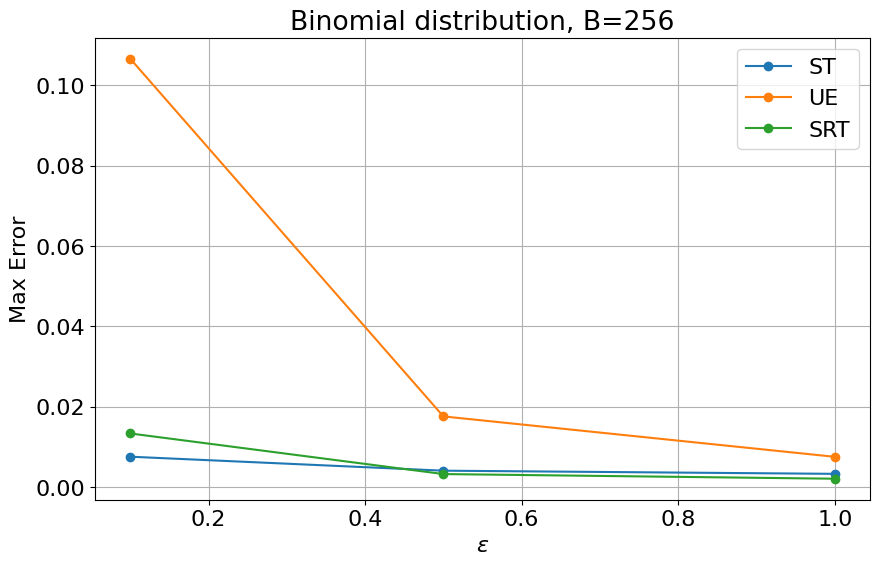

In [ ]:
#Plotting maximum errors

plt.rcParams.update({'font.size': 16})

plt.figure(figsize=(10, 6))
plt.plot(Eps, Err0_max, '-o', label = "ST")
#plt.plot(Eps[:6], Err0_max, '-o', label = "ST")
#plt.plot(range(Trials), Err1_max, '-o', label = "SRT-v1")
plt.plot(Eps, Err1_max, '-o', label = "UE")
plt.plot(Eps, Err2_max, '-o', label = "SRT")
#plt.plot(Eps[:6], Err2_max, '-o', label = "SRT-v2")

plt.title(f"Binomial distribution, B=256")
plt.xlabel(f'$ \epsilon $')
plt.ylabel('Max Error')
plt.grid(True)
plt.legend()
plt.show()

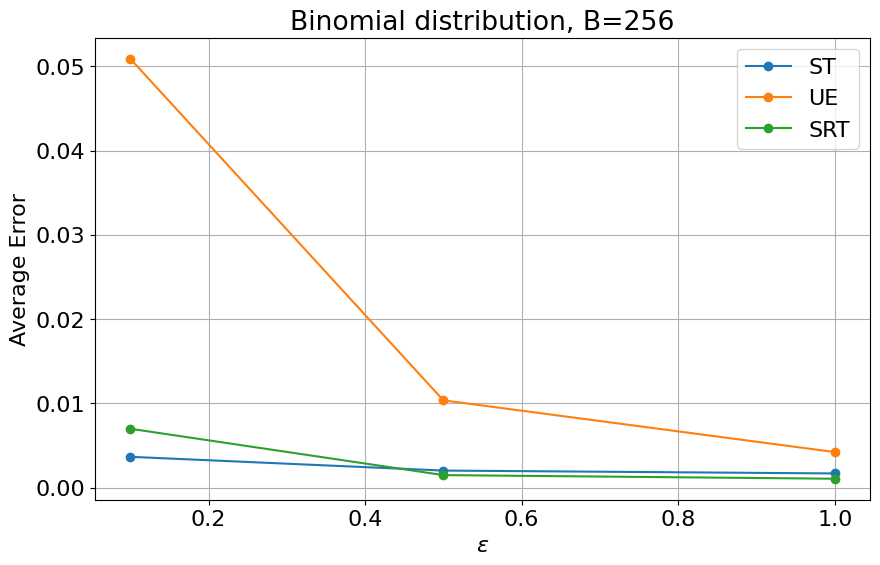

In [ ]:
#Plotting average errors

plt.rcParams.update({'font.size': 16})

plt.figure(figsize=(10, 6))
plt.plot(Eps, Err0_avg, '-o', label = "ST")
plt.plot(Eps, Err1_avg, '-o', label = "UE")
#plt.plot(range(Trials), Err1_avg, '-o', label = "SRT")
plt.plot(Eps, Err2_avg, '-o', label = "SRT")

plt.title(f"Binomial distribution, B=256")
plt.xlabel(f'$\epsilon$')
plt.ylabel('Average Error')
plt.grid(True)
plt.legend()
plt.show()

## Graphing binomial distribution

####Graphing

In [ ]:
print(min(cx0.keys()))
print(max(cx0.keys()))

68
134


In [ ]:
print(len(cx0.values() ))

67


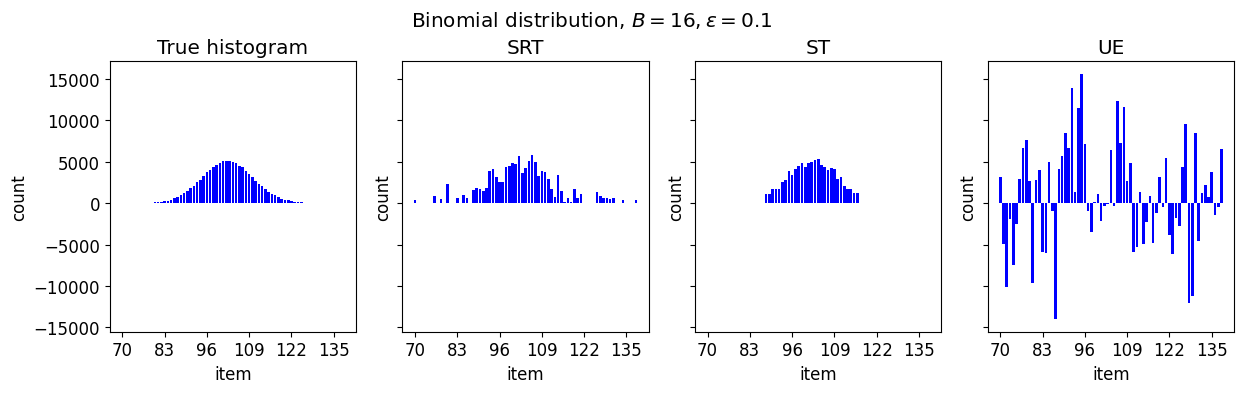

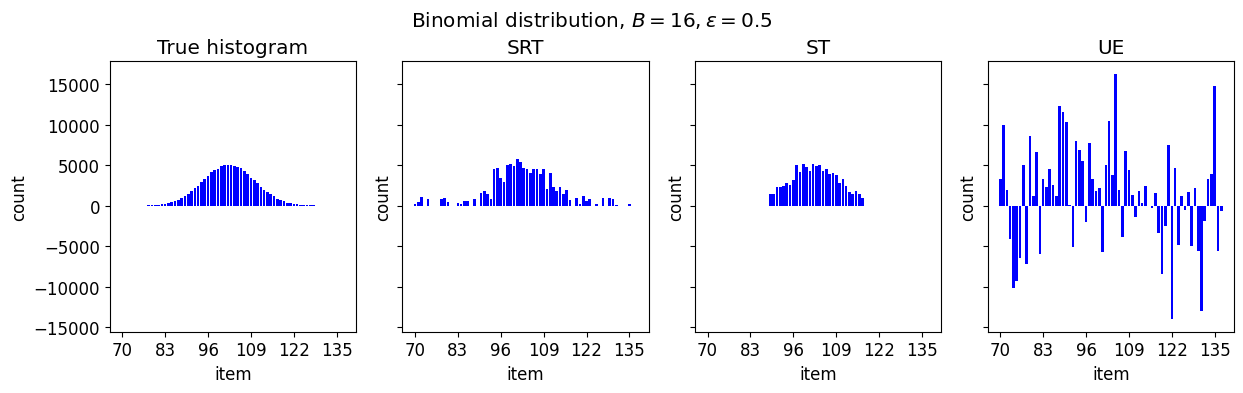

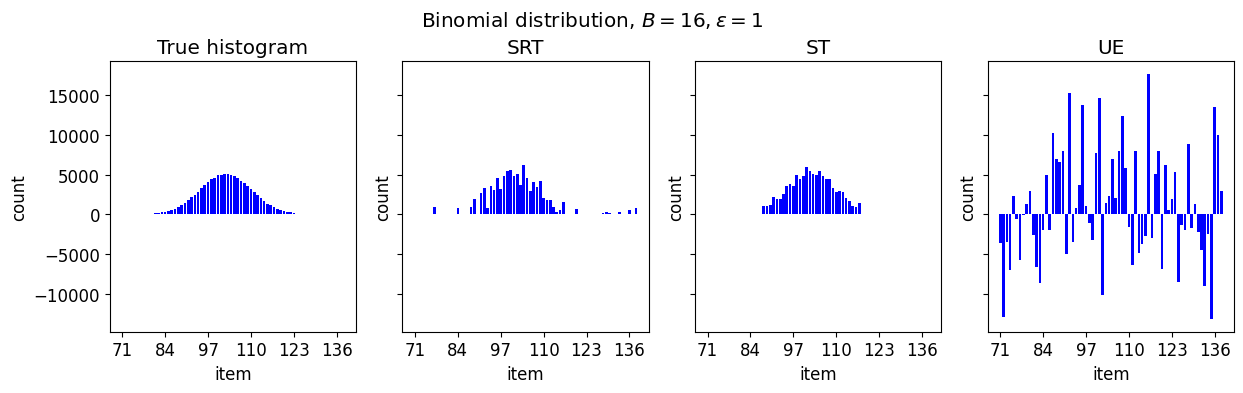

In [ ]:
#Checking dimension

import matplotlib.pyplot as plt

Eps = [0.1, 0.5, 1]
plt.rcParams.update({'font.size': 12})

B = 16

for i in [0, 1, 2]:
    cx0 = Dataset[i][0]
    calg0 = Dataset[i][1]
    calg1 = Dataset[i][2]
    calg2 = Dataset[i][3]

    f, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, sharey=True, figsize=(12, 4))
    f.suptitle(f"Binomial distribution, $B = {B}, \epsilon = {Eps[i]}$")
    stepsize = max(1, (max(cx0.keys()) - min(cx0.keys()) ) // 5)

    ax1.bar(cx0.keys(), cx0.values(),  color='b')
    ax1.set_title("True histogram")
    ax1.set_xticks(range(min(cx0.keys()), max(cx0.keys())+1, stepsize))
    ax1.set_xlabel("item")
    ax1.set_ylabel("count")

    ax3.bar(range(min(cx0.keys()), max(cx0.keys())+1), calg0[min(cx0.keys()): max(cx0.keys())+1],  color='b')
    ax3.set_title(r"ST")
    ax3.set_xticks(range(min(cx0.keys()), max(cx0.keys())+1, stepsize))
    ax3.set_xlabel("item")
    ax3.set_ylabel("count")

    ax4.bar(range(min(cx0.keys()), max(cx0.keys())+1), calg1[min(cx0.keys()): max(cx0.keys())+1],  color='b')
    ax4.set_title(r"UE")
    ax4.set_xticks(range(min(cx0.keys()), max(cx0.keys())+1, stepsize))
    ax4.set_xlabel("item")
    ax4.set_ylabel("count")

    ax2.bar(range(min(cx0.keys()), max(cx0.keys())+1), calg2[min(cx0.keys()): max(cx0.keys())+1],  color='b')
    ax2.set_title(r"SRT")
    ax2.set_xticks(range(min(cx0.keys()), max(cx0.keys())+1, stepsize))
    ax2.set_xlabel("item")
    ax2.set_ylabel("count")

    plt.tight_layout(rect=[0, 0, 1.05, 1.05])
